In [1]:
import pandas as pd
import numpy as np
# List of file paths
file_paths = [
    "spy_data/spy_2018_rth_data.csv",
    "spy_data/spy_2019_rth_data.csv",
    "spy_data/spy_2020_rth_data.csv",
    "spy_data/spy_2021_rth_data.csv",
    "spy_data/spy_2022_rth_data.csv",
    "spy_data/spy_2023_rth_data.csv",
]

# List to store the DataFrames
dataframes = []

# For loop to read each file into a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Unnamed: 0'])
    df.set_index('Time', inplace=True)
    dataframes.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dataframes)

# Combine rows with the same index by averaging
# combined_df = combined_df.groupby(combined_df.index).mean()

# Display the first few rows of the combined DataFrame
combined_df.head()


Unnamed: 0     Open     High      Low    Close  \
Time                                                                           
2018-01-02 09:35:00  2018-01-02 09:35:00  241.918  242.322  241.550  242.011   
2018-01-02 09:40:00  2018-01-02 09:40:00  242.208  242.431  241.894  242.035   
2018-01-02 09:45:00  2018-01-02 09:45:00  242.226  242.349  241.776  241.909   
2018-01-02 09:50:00  2018-01-02 09:50:00  242.099  242.277  241.731  241.949   
2018-01-02 09:55:00  2018-01-02 09:55:00  242.140  242.494  241.781  242.180   

                      Volume  
Time                          
2018-01-02 09:35:00  1719899  
2018-01-02 09:40:00  1425039  
2018-01-02 09:45:00  1474490  
2018-01-02 09:50:00   652130  
2018-01-02 09:55:00   945838

In [2]:
combined_df['Date'] = combined_df.index.date

# Load VIX historical data
vix_data = pd.read_csv('VIX_History.csv')

# Convert the DATE column to datetime
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])

# Merge SPY and VIX data on Date
merged_data = pd.merge(combined_df, vix_data[['DATE', 'CLOSE']], left_on='Date', right_on=vix_data['DATE'].dt.date, how='left')

# Rename the VIX CLOSE column for clarity
merged_data = merged_data.rename(columns={'CLOSE': 'VIX'})

# Drop the redundant DATE column
merged_data = merged_data.drop(columns=['DATE'])

In [3]:
merged_data['Unnamed: 0'] = pd.to_datetime(merged_data['Unnamed: 0'])
merged_data.set_index('Unnamed: 0', inplace=True)
merged_data.head(82)
# print(len(combined_df))

Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2018-01-02 09:35:00  241.918  242.322  241.550  242.011  1719899  2018-01-02   
2018-01-02 09:40:00  242.208  242.431  241.894  242.035  1425039  2018-01-02   
2018-01-02 09:45:00  242.226  242.349  241.776  241.909  1474490  2018-01-02   
2018-01-02 09:50:00  242.099  242.277  241.731  241.949   652130  2018-01-02   
2018-01-02 09:55:00  242.140  242.494  241.781  242.180   945838  2018-01-02   
...                      ...      ...      ...      ...      ...         ...   
2018-01-02 16:00:00  243.103  243.227  242.382  242.740  2938096  2018-01-02   
2018-01-02 16:05:00  242.922  243.199  242.517  242.632   640408  2018-01-02   
2018-01-02 16:10:00  243.085  243.195  242.499  242.677  2741770  2018-01-02   
2018-01-02 16:15:00  243.088  243.194  242.544  242.668   577666  2018-01-02   
2018-01-03 09:35:00  243.356  243.734  243.014  243.427  1326704  2018-01-03   

                      VIX  
Unnamed: 0                 
2018-01-02 09:35:00  9.77  
2018-01-02 09:40:00  9.77  
2018-01-02 09:45:00  9.77  
2018-01-02 09:50:00  9.77  
2018-01-02 09:55:00  9.77  
...                   ...  
2018-01-02 16:00:00  9.77  
2018-01-02 16:05:00  9.77  
2018-01-02 16:10:00  9.77  
2018-01-02 16:15:00  9.77  
2018-01-03 09:35:00  9.15  

[82 rows x 7 columns]

### calculate average bar range from past ten bars

In [4]:
def calculate_atr(df, period=14):
    # Calculate True Range (TR)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)

    df['previous_close'] = df['Close'].shift(1)
    df['previous_high'] = df['High'].shift(1)
    df['previous_low'] = df['Low'].shift(1)
    df['previous_open'] = df['Open'].shift(1)
    df['tr1'] = df['High'] - df['Low']
    df['tr2'] = abs(df['High'] - df['previous_close'])
    df['tr3'] = abs(df['Low'] - df['previous_close'])
    df['True_Range'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

    # Calculate ATR
    df['ATR'] = df['True_Range'].rolling(window=period).mean()
    # Calculate ABR
    df['ABR'] = df['tr1'].shift(1).rolling(window=10).mean()
    # Calculate bar overlap
    df['overlap_high'] = np.minimum(df['High'], df['previous_high'])
    df['overlap_low'] = np.maximum(df['Low'], df['previous_low'])
    df['non_overlap'] = np.maximum((df['overlap_low'] - df['Low']), (df['High'] - df['overlap_high']))
    
        # creating feature
    df['close_diff'] = (df['Close'] - df['previous_close']) * 10
    df['high_diff'] = (df['High'] - df['previous_high']) * 10
    df['low_diff'] = (df['Low'] - df['previous_low']) * 10
    df['open_diff'] = (df['Open'] - df['previous_open']) * 10
    return df

atr_df = calculate_atr(merged_data)

# Display the DataFrame with ATR
print(atr_df.head(15))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2018-01-02 09:35:00  241.918  242.322  241.550  242.011  1719899  2018-01-02   
2018-01-02 09:40:00  242.208  242.431  241.894  242.035  1425039  2018-01-02   
2018-01-02 09:45:00  242.226  242.349  241.776  241.909  1474490  2018-01-02   
2018-01-02 09:50:00  242.099  242.277  241.731  241.949   652130  2018-01-02   
2018-01-02 09:55:00  242.140  242.494  241.781  242.180   945838  2018-01-02   
2018-01-02 10:00:00  242.366  242.693  242.056  242.297  2042640  2018-01-02   
2018-01-02 10:05:00  242.486  242.738  242.183  242.424   751749  2018-01-02   
2018-01-02 10:10:00  242.615  242.720  242.228  242.343   650656  2018-01-02   
2018-01-02 10:15:00  242.542  242.775  242.246  242.415   646122  2018-01-02   
2018-01-02 10:20:00  242.610  242.757  242.282  242.410   355308  2018-01-02   
2018-01-02 10:25:00  242.606  242.874  2

In [5]:
print(atr_df.head(50))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2018-01-02 09:35:00  241.918  242.322  241.550  242.011  1719899  2018-01-02   
2018-01-02 09:40:00  242.208  242.431  241.894  242.035  1425039  2018-01-02   
2018-01-02 09:45:00  242.226  242.349  241.776  241.909  1474490  2018-01-02   
2018-01-02 09:50:00  242.099  242.277  241.731  241.949   652130  2018-01-02   
2018-01-02 09:55:00  242.140  242.494  241.781  242.180   945838  2018-01-02   
2018-01-02 10:00:00  242.366  242.693  242.056  242.297  2042640  2018-01-02   
2018-01-02 10:05:00  242.486  242.738  242.183  242.424   751749  2018-01-02   
2018-01-02 10:10:00  242.615  242.720  242.228  242.343   650656  2018-01-02   
2018-01-02 10:15:00  242.542  242.775  242.246  242.415   646122  2018-01-02   
2018-01-02 10:20:00  242.610  242.757  242.282  242.410   355308  2018-01-02   
2018-01-02 10:25:00  242.606  242.874  2

In [6]:
atr_df["Open"] = atr_df["Open"].astype(float)
atr_df["High"] = atr_df["High"].astype(float)
atr_df["Low"] = atr_df["Low"].astype(float)
atr_df["Close"] = atr_df["Close"].astype(float)
atr_df["ATR"] = atr_df["ATR"].astype(float)
atr_df["ABR"] = atr_df["ABR"].astype(float)
atr_df["open_diff"] = atr_df["open_diff"].astype(float)
atr_df["high_diff"] = atr_df["high_diff"].astype(float)
atr_df["low_diff"] = atr_df["low_diff"].astype(float)
atr_df["close_diff"] = atr_df["close_diff"].astype(float)
# Filter the data for May 2024
may_df = atr_df[atr_df.index.month == 5]

print(may_df.head(50))

                        Open     High      Low    Close   Volume        Date  \
Unnamed: 0                                                                     
2018-05-01 09:35:00  239.416  239.708  238.862  239.047  1476366  2018-05-01   
2018-05-01 09:40:00  239.225  239.499  238.889  239.020   721578  2018-05-01   
2018-05-01 09:45:00  239.207  239.654  238.898  239.274   693475  2018-05-01   
2018-05-01 09:50:00  239.489  239.699  239.025  239.238   495342  2018-05-01   
2018-05-01 09:55:00  239.421  239.890  239.125  239.474   669867  2018-05-01   
2018-05-01 10:00:00  239.643  239.808  238.998  239.129   913381  2018-05-01   
2018-05-01 10:05:00  239.316  239.454  238.717  238.911   955354  2018-05-01   
2018-05-01 10:10:00  239.098  239.481  238.690  239.138   941695  2018-05-01   
2018-05-01 10:15:00  239.325  239.563  238.860  239.211   618206  2018-05-01   
2018-05-01 10:20:00  239.407  239.707  239.034  239.311   815727  2018-05-01   
2018-05-01 10:25:00  239.498  239.617  2

In [7]:
# List of columns to drop
columns_to_drop = ['Volume', 'previous_close', 'tr2', 'tr3', 'True_Range', 'previous_high', 'previous_low', 'previous_open']

# Drop the columns
atr_df = atr_df.drop(columns=columns_to_drop)

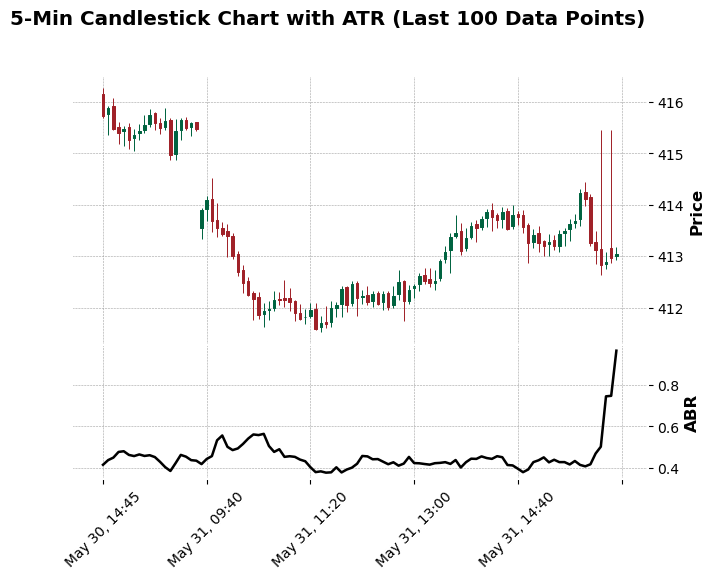

In [8]:
import mplfinance as mpf

last_100_df = may_df.tail(100)

# Prepare the DataFrame for mplfinance
last_100_df = last_100_df[['Open', 'High', 'Low', 'Close', 'ATR', 'ABR']]

# Plot the candlestick chart with ATR for the last 100 data points
apd = [mpf.make_addplot(last_100_df['ATR'], panel=1, color='blue', ylabel='ATR'), mpf.make_addplot(last_100_df['ABR'], panel=1, color='k', ylabel='ABR')]
mpf.plot(last_100_df, type='candle', style='charles', addplot=apd[1], title=f'5-Min Candlestick Chart with ATR (Last 100 Data Points)', ylabel='Price', panel_ratios=(2, 1))

### label and highlight the data

In [9]:
import pandas as pd
df = pd.DataFrame(atr_df)
if 'label' not in df.columns:
    df['label'] = 0
if 'highlight' not in df.columns:
    df['highlight'] = False

print(df.head(10))
print(len(df))
for idx, row in enumerate(df.itertuples(index=True, name='Pandas')):
    # print(f"Before updating label: Index {row.Index}, Label {atr_df.at[row.Index, 'label']}")
    # atr_df.at[row.Index, 'label'] = 1.0
    # print(f"After updating label: Index {row.Index}, Label {atr_df.at[row.Index, 'label']}")
    if idx == 0:
        df.at[row.Index, 'close_diff'] = 0
        df.at[row.Index, 'high_diff'] = 0
        df.at[row.Index, 'low_diff'] = 0
        df.at[row.Index, 'open_diff'] = 0

    if pd.isna(row.ATR):
        df.at[row.Index, 'label'] = 0
        # print(row.Index, row.Open, row.High, row.Low, row.Close, row.ATR, row.label)
        continue
    # highlight the large bar
    if pd.isna(row.ABR) or row.tr1 < 1.05* row.ABR or row.non_overlap < 0.4*row.tr1:
        df.at[row.Index, 'highlight'] = False
        df.at[row.Index, 'label'] = 0
    
    elif row.tr1 >= 1.05*row.ABR and row.non_overlap >= 0.4*row.tr1:
        df.at[row.Index, 'highlight'] = True
        
    two_atr = row.ATR * 1.0
    pos_target = row.Close + two_atr
    neg_target = row.Close - two_atr

    label = 0
    # Get the close price of the next row
    for i in range(1, (len(df) - idx)):
        next_row = df.iloc[idx + i]
        if next_row.High >= pos_target and next_row.Low <= neg_target:
            if next_row.Close > next_row.Open:
                label = 1
            elif next_row.Close < next_row.Open:
                label = -1
            break
        elif next_row.High >= pos_target:
            label = 1
            break
        elif next_row.Low <= neg_target:
            label = -1
            break
    df.at[row.Index, 'label'] = label
    # print(row.Index, row.Open, row.High, row.Low, row.Close, row.ATR, row.label)
print("after change")
print(df.head(10))

                        Open     High      Low    Close        Date   VIX  \
Unnamed: 0                                                                  
2018-01-02 09:35:00  241.918  242.322  241.550  242.011  2018-01-02  9.77   
2018-01-02 09:40:00  242.208  242.431  241.894  242.035  2018-01-02  9.77   
2018-01-02 09:45:00  242.226  242.349  241.776  241.909  2018-01-02  9.77   
2018-01-02 09:50:00  242.099  242.277  241.731  241.949  2018-01-02  9.77   
2018-01-02 09:55:00  242.140  242.494  241.781  242.180  2018-01-02  9.77   
2018-01-02 10:00:00  242.366  242.693  242.056  242.297  2018-01-02  9.77   
2018-01-02 10:05:00  242.486  242.738  242.183  242.424  2018-01-02  9.77   
2018-01-02 10:10:00  242.615  242.720  242.228  242.343  2018-01-02  9.77   
2018-01-02 10:15:00  242.542  242.775  242.246  242.415  2018-01-02  9.77   
2018-01-02 10:20:00  242.610  242.757  242.282  242.410  2018-01-02  9.77   

                       tr1  ATR  ABR  overlap_high  overlap_low  non_overla

In [10]:
print(df.head(10))

                        Open     High      Low    Close        Date   VIX  \
Unnamed: 0                                                                  
2018-01-02 09:35:00  241.918  242.322  241.550  242.011  2018-01-02  9.77   
2018-01-02 09:40:00  242.208  242.431  241.894  242.035  2018-01-02  9.77   
2018-01-02 09:45:00  242.226  242.349  241.776  241.909  2018-01-02  9.77   
2018-01-02 09:50:00  242.099  242.277  241.731  241.949  2018-01-02  9.77   
2018-01-02 09:55:00  242.140  242.494  241.781  242.180  2018-01-02  9.77   
2018-01-02 10:00:00  242.366  242.693  242.056  242.297  2018-01-02  9.77   
2018-01-02 10:05:00  242.486  242.738  242.183  242.424  2018-01-02  9.77   
2018-01-02 10:10:00  242.615  242.720  242.228  242.343  2018-01-02  9.77   
2018-01-02 10:15:00  242.542  242.775  242.246  242.415  2018-01-02  9.77   
2018-01-02 10:20:00  242.610  242.757  242.282  242.410  2018-01-02  9.77   

                       tr1  ATR  ABR  overlap_high  overlap_low  non_overla

In [11]:
print("\nRows where the label is -1:")
rows_with_label_0 = df[df['label'] == 0]
print(len(rows_with_label_0))


Rows where the label is -1:
14


### preparing data

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# # Assuming df is your DataFrame with OHLC data, 'Date' column, and 'label' column
# df['Date'] = pd.to_datetime(df['Unnamed: 0'])
# df = df.set_index('Date')

# Create sequences of past twenty days' OHLC data
sequence_length = 30

# Prepare the input features and labels
features = []
labels = []
dates = []
highlights = []

for i in range(len(df) - sequence_length):
    features.append(df[['open_diff', 'high_diff', 'low_diff', 'close_diff']].iloc[i:i + sequence_length].values)
    labels.append(df['label'].iloc[i + sequence_length])
    dates.append(df.index[i + sequence_length])
    highlights.append(df['highlight'].iloc[i + sequence_length])

features = np.array(features)
labels = np.array(labels)
dates = np.array(dates)
highlights = np.array(highlights)

# Normalize the features within each data point using Standard Scaler
scaler = StandardScaler()
for i in range(features.shape[0]):
    features[i] = scaler.fit_transform(features[i])
# store the original labels for later use
all_labels = labels
# Convert -1 labels to 0 for binary classification
labels = np.where(labels == -1, 0, 1)

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)



In [13]:
print(features[:2])
# print(labels[:1000])

tensor([[[-0.2111, -0.1802, -0.1957, -0.1731],
         [ 2.8197,  1.2061,  2.8237,  0.1160],
         [-0.0230, -1.2231, -1.2315, -1.6908],
         [-1.5384, -1.0959, -0.5907,  0.3088],
         [ 0.2174,  2.5797,  0.2431,  2.6095],
         [ 2.1508,  2.3508,  2.2180,  1.2363],
         [ 1.0430,  0.3921,  0.9190,  1.3567],
         [ 1.1371, -0.4091,  0.1992, -1.1487],
         [-0.9740,  0.5193, -0.0377,  0.6942],
         [ 0.4996, -0.4091,  0.1203, -0.2333],
         [-0.2529,  1.3079,  0.0413,  1.7422],
         [ 1.3879,  0.1632,  0.4450, -0.6187],
         [-0.4933, -0.1802, -3.0572, -2.0160],
         [-1.8205, -1.8972,  1.3140, -0.1731],
         [-0.2529, -0.5363,  0.1992,  0.3088],
         [ 0.1651,  0.4049,  0.1641,  0.4292],
         [ 0.3532, -0.2946, -0.1606, -0.3899],
         [-0.4410, -0.0657, -0.1957,  0.1522],
         [-0.0230, -0.2946, -0.1167, -0.3899],
         [-0.2634, -0.0657, -0.1957,  0.0438],
         [ 0.0293,  0.8500, -0.0377,  0.2606],
         [ 0.

In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = TimeSeriesDataset(features, labels)

In [15]:
# # Split the data
# train_size = int(1.0 * len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # Create DataLoader for testing set
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
print(features[0])

tensor([[-0.2111, -0.1802, -0.1957, -0.1731],
        [ 2.8197,  1.2061,  2.8237,  0.1160],
        [-0.0230, -1.2231, -1.2315, -1.6908],
        [-1.5384, -1.0959, -0.5907,  0.3088],
        [ 0.2174,  2.5797,  0.2431,  2.6095],
        [ 2.1508,  2.3508,  2.2180,  1.2363],
        [ 1.0430,  0.3921,  0.9190,  1.3567],
        [ 1.1371, -0.4091,  0.1992, -1.1487],
        [-0.9740,  0.5193, -0.0377,  0.6942],
        [ 0.4996, -0.4091,  0.1203, -0.2333],
        [-0.2529,  1.3079,  0.0413,  1.7422],
        [ 1.3879,  0.1632,  0.4450, -0.6187],
        [-0.4933, -0.1802, -3.0572, -2.0160],
        [-1.8205, -1.8972,  1.3140, -0.1731],
        [-0.2529, -0.5363,  0.1992,  0.3088],
        [ 0.1651,  0.4049,  0.1641,  0.4292],
        [ 0.3532, -0.2946, -0.1606, -0.3899],
        [-0.4410, -0.0657, -0.1957,  0.1522],
        [-0.0230, -0.2946, -0.1167, -0.3899],
        [-0.2634, -0.0657, -0.1957,  0.0438],
        [ 0.0293,  0.8500, -0.0377,  0.2606],
        [ 0.1651, -0.7525, -1.1437

### Positional encoding 

In [18]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

### building transformer model

In [19]:
class EncoderOnlyTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout):
        super(EncoderOnlyTransformerModel, self).__init__()
        self.seq_len = sequence_length
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim, max_len=self.seq_len)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc2 = nn.Linear(hidden_dim*self.seq_len, output_dim)

    def create_mask(self, seq_len, device):
        mask = nn.Transformer.generate_square_subsequent_mask(self=self, sz=seq_len).to(device)
        return mask

    def forward(self, src):
        src = self.fc1(src)  # Linear layer
        src = src.permute(1, 0, 2)  # Change shape to (seq_len, batch_size, hidden_dim)
        src = self.positional_encoding(src) # Apply positional encoding
        attention_mask = self.create_mask(src.size(0), src.device)
        output = self.transformer_encoder(src, mask=attention_mask)
        output = output.permute(1, 0, 2)  # Change shape back to (batch_size, seq_len, hidden_dim)
        output = output.reshape(output.size(0), -1)  # Flatten the sequence (batch_size, seq_len * hidden_dim)
        output = self.fc2(output)  # Classification layer
        return output
# Example usage
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = EncoderOnlyTransformerModel(input_dim=4, hidden_dim=128, output_dim=1, num_layers=2, num_heads=4, dropout=0.1).to(device)

In [20]:
import pandas as pd
import numpy as np

# Assuming merged_data already includes the necessary data
df['Date'] = pd.to_datetime(df['Date'])
test_indices = np.load('test_indices.npy', allow_pickle=True).tolist()
test_data = df.loc[test_indices]
unique_dates = test_data['Date'].unique()

print(unique_dates)

['2022-02-04T00:00:00.000000000' '2022-02-16T00:00:00.000000000'
 '2022-02-17T00:00:00.000000000' '2022-03-16T00:00:00.000000000'
 '2022-03-21T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-04-22T00:00:00.000000000' '2022-07-11T00:00:00.000000000'
 '2022-08-01T00:00:00.000000000' '2022-08-10T00:00:00.000000000'
 '2022-08-25T00:00:00.000000000' '2022-09-13T00:00:00.000000000'
 '2022-09-16T00:00:00.000000000' '2022-10-28T00:00:00.000000000'
 '2022-11-17T00:00:00.000000000' '2022-11-21T00:00:00.000000000'
 '2022-12-06T00:00:00.000000000' '2022-12-07T00:00:00.000000000'
 '2022-12-27T00:00:00.000000000' '2023-01-05T00:00:00.000000000'
 '2023-01-11T00:00:00.000000000' '2023-01-30T00:00:00.000000000'
 '2023-02-14T00:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-03-15T00:00:00.000000000' '2023-03-24T00:00:00.000000000'
 '2023-03-27T00:00:00.000000000' '2023-04-10T00:00:00.000000000'
 '2023-04-19T00:00:00.000000000' '2023-04-24T00:00:00.000000000'
 '2023-08-02T00:00:00.000

In [21]:
import torch.optim as optim

val_indices_all = [j for j, (date, highlight) in enumerate(zip(dates, highlights)) if date in test_indices and highlight]
val_subset = torch.utils.data.Subset(dataset, val_indices_all)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
# Hyperparameters
num_epochs = 2000
learning_rate = 0.0001

years = sorted(set(df.index.year))
results = []
train_indices = []
for i in range(0,4):
    train_year = years[i]
    # Train and test split based on year
    train_indice = [j for j, (date, highlight) in enumerate(zip(dates, highlights)) if (date.year == train_year)]
    train_indices.extend(train_indice)
    # test_indices = [j for j, date in enumerate(dates) if date.year == test_year]

train_subset = torch.utils.data.Subset(dataset, train_indices)
# test_subset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=False)
# test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

model = EncoderOnlyTransformerModel(input_dim=4, hidden_dim=128, output_dim=1, num_layers=2, num_heads=4, dropout=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_model_state = None
best_val_loss = float('inf')
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(features.to(device))
        loss = nn.functional.binary_cross_entropy_with_logits(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}")
    # Making predictions on the test set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            labels = labels.unsqueeze(1).to(device)
            features = features.to(device)
            outputs = model(features)
            loss = nn.functional.binary_cross_entropy_with_logits(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f"epoch: {epoch+1} val loss", val_loss)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, f"2018_model_transformer_{sequence_length}_best_pos_nomask.pth")
        print(f"New best model found at epoch {epoch} with val loss {val_loss}")
# Save the model for later testing
torch.save(model.state_dict(), f"2018_model_transformer_{sequence_length}_last_pos_nomask.pth")

Epoch [1/2000], Train Loss: 0.7022
epoch: 1 val loss 0.7032951867138898
New best model found at epoch 0 with val loss 0.7032951867138898
Epoch [2/2000], Train Loss: 0.6942
epoch: 2 val loss 0.6942822403377957
New best model found at epoch 1 with val loss 0.6942822403377957
Epoch [3/2000], Train Loss: 0.6898
epoch: 3 val loss 0.6930986179245843
New best model found at epoch 2 with val loss 0.6930986179245843
Epoch [4/2000], Train Loss: 0.6878
epoch: 4 val loss 0.6935995618502299
Epoch [5/2000], Train Loss: 0.6868
epoch: 5 val loss 0.6931747440938596
Epoch [6/2000], Train Loss: 0.6852
epoch: 6 val loss 0.6930044933601662
New best model found at epoch 5 with val loss 0.6930044933601662
Epoch [7/2000], Train Loss: 0.6849
epoch: 7 val loss 0.6927753421995375
New best model found at epoch 6 with val loss 0.6927753421995375
Epoch [8/2000], Train Loss: 0.6846
epoch: 8 val loss 0.6924874694259079
New best model found at epoch 7 with val loss 0.6924874694259079
Epoch [9/2000], Train Loss: 0.6845

### sample testing data

In [ ]:
# import pandas as pd
# import numpy as np
# Assuming merged_data already includes the necessary data
# df['Date'] = pd.to_datetime(df['Date'])
# merged_data_testing = df[df['Date'] >= pd.to_datetime('2022-01-01')]
# # Calculate the number of samples needed for 50 days based on the given distribution
# total_days = 50
# mid_vix_percentage = 0.71396396
# low_vix_percentage = 0.22409910
# high_vix_percentage = 0.06193694

# mid_vix_days = int(total_days * mid_vix_percentage)
# low_vix_days = int(total_days * low_vix_percentage)
# high_vix_days = int(total_days * high_vix_percentage)

# # Ensure the total number of days sums to 50
# remaining_days = total_days - (mid_vix_days + low_vix_days + high_vix_days)
# if remaining_days > 0:
#     mid_vix_days += remaining_days

# # Sample unique dates for each category
# mid_vix_dates = np.random.choice(
#     merged_data_testing[(merged_data_testing['VIX'] >= 15) & (merged_data_testing['VIX'] < 30)]['Date'].unique(),
#     mid_vix_days,
#     replace=False
# )
# low_vix_dates = np.random.choice(
#     merged_data_testing[merged_data_testing['VIX'] < 15]['Date'].unique(),
#     low_vix_days,
#     replace=False
# )
# high_vix_dates = np.random.choice(
#     merged_data_testing[merged_data_testing['VIX'] >= 30]['Date'].unique(),
#     high_vix_days,
#     replace=False
# )
# # Filter the data for the selected dates
# mid_vix_data_indices = merged_data_testing[merged_data_testing['Date'].isin(mid_vix_dates)].index.tolist()
# low_vix_data_indices = merged_data_testing[merged_data_testing['Date'].isin(low_vix_dates)].index.tolist()
# high_vix_data_indices = merged_data_testing[merged_data_testing['Date'].isin(high_vix_dates)].index.tolist()

# # Combine the indices
# test_indices = mid_vix_data_indices + low_vix_data_indices + high_vix_data_indices

# print(test_indices)
# # Save to NumPy binary file
# np.save('test_indices.npy', test_indices)

In [ ]:
import pandas as pd
import numpy as np

# Assuming merged_data already includes the necessary data
df['Date'] = pd.to_datetime(df['Date'])
test_indices = np.load('test_indices.npy', allow_pickle=True).tolist()
test_data = df.loc[test_indices]
unique_dates = test_data['Date'].unique()

print(unique_dates)

['2022-02-04T00:00:00.000000000' '2022-02-16T00:00:00.000000000'
 '2022-02-17T00:00:00.000000000' '2022-03-16T00:00:00.000000000'
 '2022-03-21T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-04-22T00:00:00.000000000' '2022-07-11T00:00:00.000000000'
 '2022-08-01T00:00:00.000000000' '2022-08-10T00:00:00.000000000'
 '2022-08-25T00:00:00.000000000' '2022-09-13T00:00:00.000000000'
 '2022-09-16T00:00:00.000000000' '2022-10-28T00:00:00.000000000'
 '2022-11-17T00:00:00.000000000' '2022-11-21T00:00:00.000000000'
 '2022-12-06T00:00:00.000000000' '2022-12-07T00:00:00.000000000'
 '2022-12-27T00:00:00.000000000' '2023-01-05T00:00:00.000000000'
 '2023-01-11T00:00:00.000000000' '2023-01-30T00:00:00.000000000'
 '2023-02-14T00:00:00.000000000' '2023-03-01T00:00:00.000000000'
 '2023-03-15T00:00:00.000000000' '2023-03-24T00:00:00.000000000'
 '2023-03-27T00:00:00.000000000' '2023-04-10T00:00:00.000000000'
 '2023-04-19T00:00:00.000000000' '2023-04-24T00:00:00.000000000'
 '2023-08-02T00:00:00.000

In [80]:
# Load the best model (assuming you have saved the best model during cross-validation)
model = EncoderOnlyTransformerModel(input_dim=4, hidden_dim=128, output_dim=1, num_layers=2, num_heads=4, dropout=0.1).to(device)
model.load_state_dict(torch.load(f'2018_model_transformer_{sequence_length}_last.pth'))
model.eval()

test_indices_all = []

for i in range(0,4):
    train_year = years[i]
    # Train and test split based on year
    train_indice = [j for j, (date, highlight) in enumerate(zip(dates, highlights)) if (date.year == train_year) and highlight]
    test_indices_all.extend(train_indice)
    
# test_indices_all = [j for j, (date) in enumerate(dates) if date in test_indices ]
print(test_indices_all)
test_subset = torch.utils.data.Subset(dataset, test_indices_all)

test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

  # Making predictions on the test set
all_predictions = []
test_true_labels = []
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)  # Move features to device
        labels = labels.to(device)  # Move labels to device
        outputs = torch.sigmoid(model(features))
        all_predictions.extend(outputs.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions).flatten()
# all_labels_test = all_labels[test_indices_all]
test_true_labels = np.array(test_true_labels)
test_true_labels = np.where(test_true_labels == 0, -1, 1)
  # Print the maximum value of the predictions for verification
print(all_predictions.max())
print(all_predictions.min())


# Print some sample predictions
# print('Sample Predictions:')
# for i in range(min(10, len(binary_predictions))):
#     print(f'Predicted: {binary_predictions[i]}, Actual: {all_labels_test[i]}')



4050
1.0
1.4205999e-09


In [90]:

upper = 0.7
lower = 0.3
# binary_predictions = np.where(all_predictions >= upper, 1, np.where(all_predictions <= lower, -1, 0))
binary_predictions = np.where(all_predictions >= 0.5, 1, -1)


train_indices_all = []
for i in range(0,4):
    train_year = years[i]
    # Train and test split based on year
    train_indice = [date for (date, highlight) in zip(dates, highlights) if (date.year == train_year) and highlight]
    train_indices_all.extend(train_indice)
    
test_data = df.loc[train_indices_all]   

test_data = df.loc[test_indices]
# Assuming `all_predictions` and `all_labels` are already defined
test_data['Predicted_Label'] = binary_predictions


# evaluate perfomance
counter = 0
correct_counter = 0
true_counter = 0
true_positives_counter = 0
unique_dates = test_data['Date'].unique()
for unique_date in unique_dates:
    # Filter data for the current date
    daily_data = test_data[test_data['Date'] == unique_date]
    for date, row in daily_data.iterrows():
      if(row['highlight']):
        true_counter += 1
        if(row['label'] == 1):
          true_positives_counter += 1
        if (row['Predicted_Label'] == 1 or row['Predicted_Label'] == -1):
          counter += 1
          if row['Predicted_Label'] == row['label']:
            correct_counter += 1
        
      
# Calculate accuracy
#   Calculate precision
# true_positives = np.sum((binary_predictions == 1) & (all_labels_test == 1))
# false_positives = np.sum((binary_predictions == 1) & (all_labels_test != 1))
# true_negatives = np.sum((binary_predictions == -1) & (all_labels_test == -1))
# false_negatives = np.sum((binary_predictions == -1) & (all_labels_test != -1))
# precision = 100 * true_positives / (true_positives + false_positives)
# precision_down = 100 * true_negatives / (true_negatives + false_negatives)
# accuracy = 100 * np.mean(binary_predictions == all_labels_test)
# print(f'Accuracy: {accuracy: .2f}%, Precision: {precision: .2f}%, Precision -1: {precision_down: .2f}%')

accuracy = 100 * correct_counter / counter
distribution = 100 * true_positives_counter / true_counter
print(f'Distribution: {distribution: .2f}%')
print(f'Accuracy: {accuracy: .2f}%')

Distribution:  50.36%
Accuracy:  50.12%


In [88]:
print(sequence_length)

30


In [89]:
print(counter)
print(true_positives_counter)
print(true_counter)

736
420
834


### Ploting

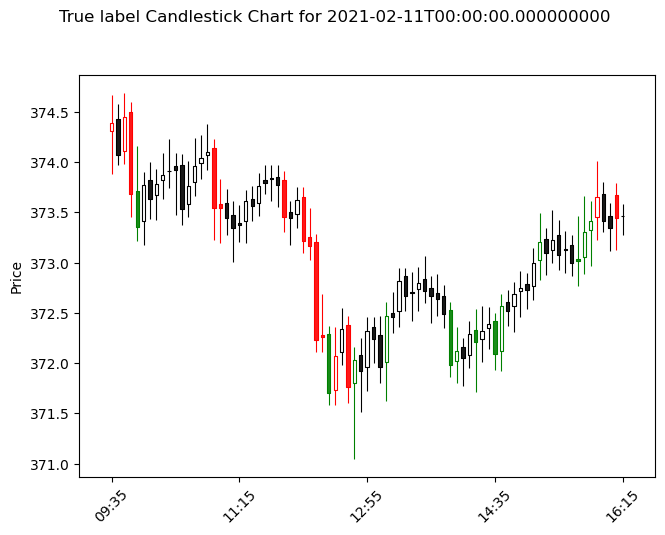

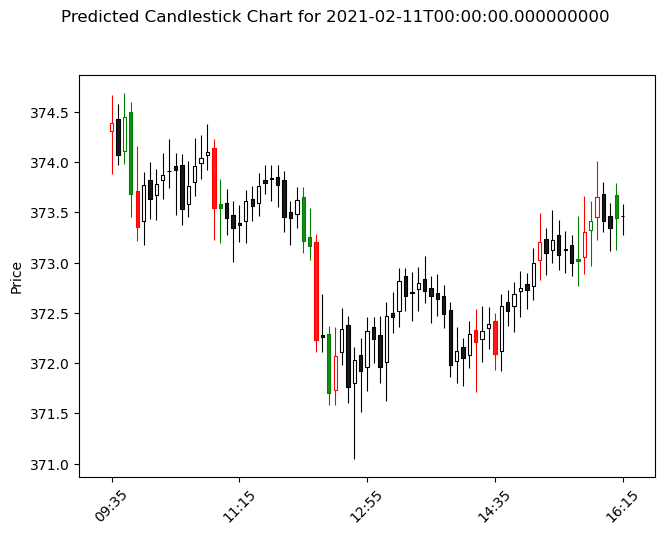

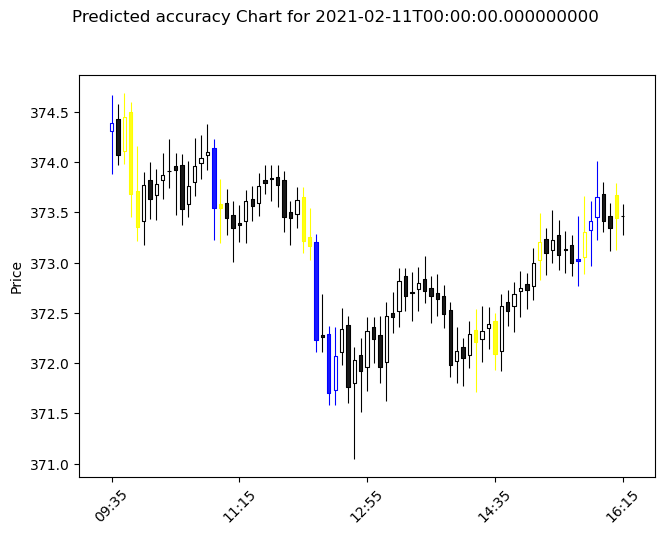

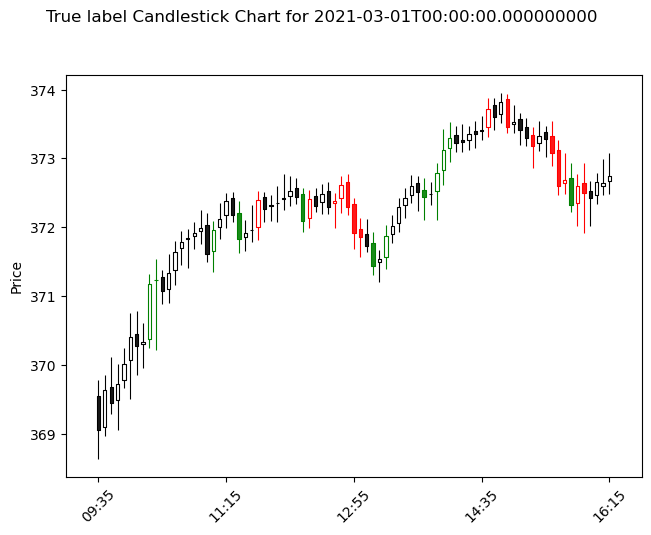

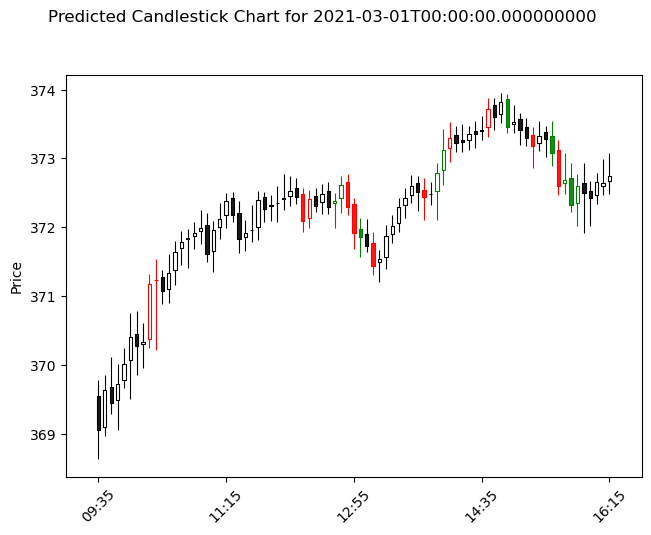

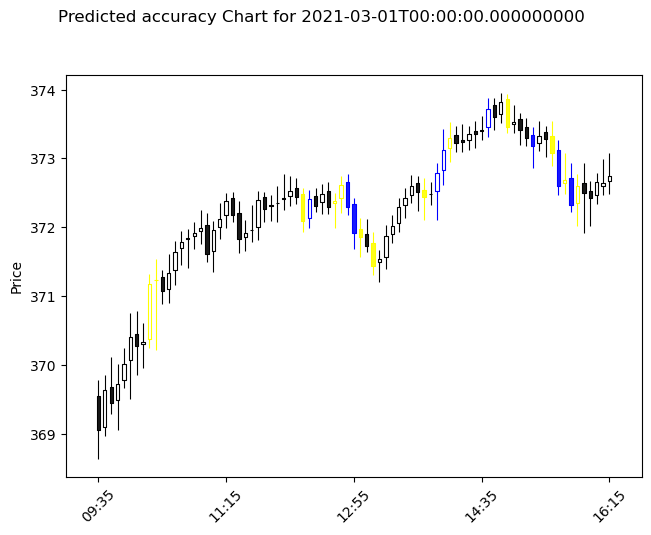

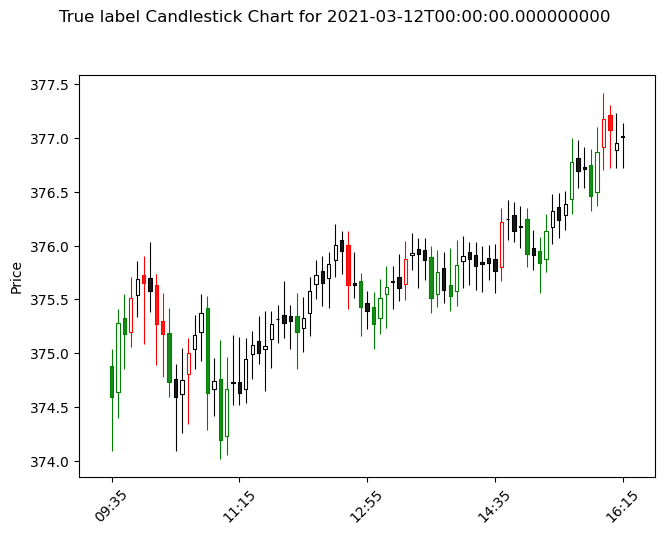

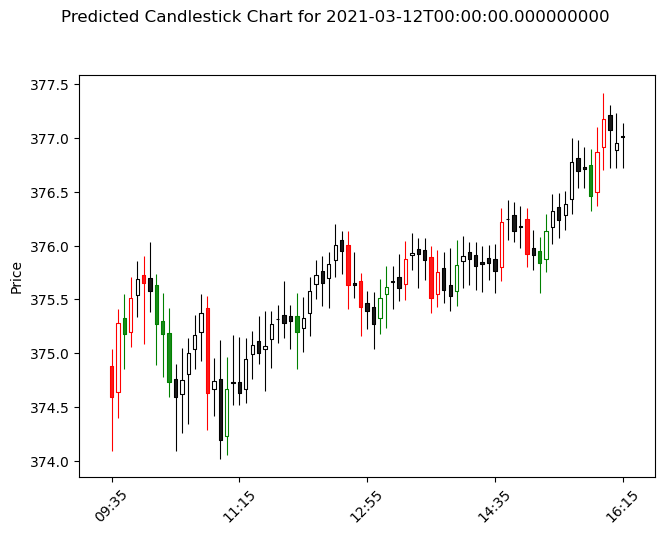

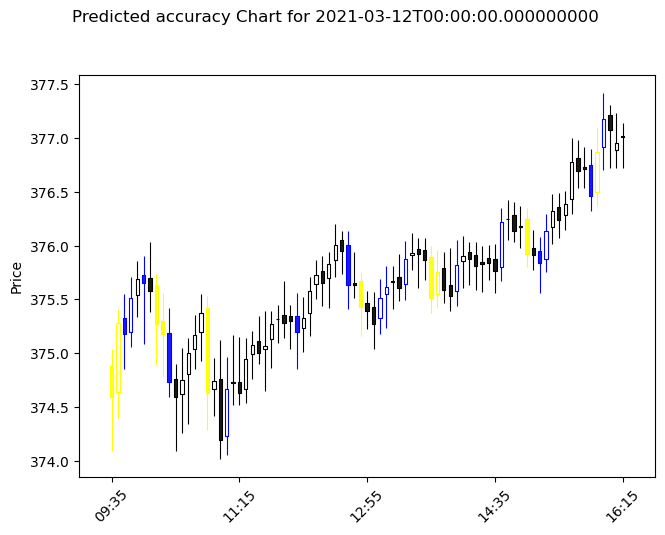

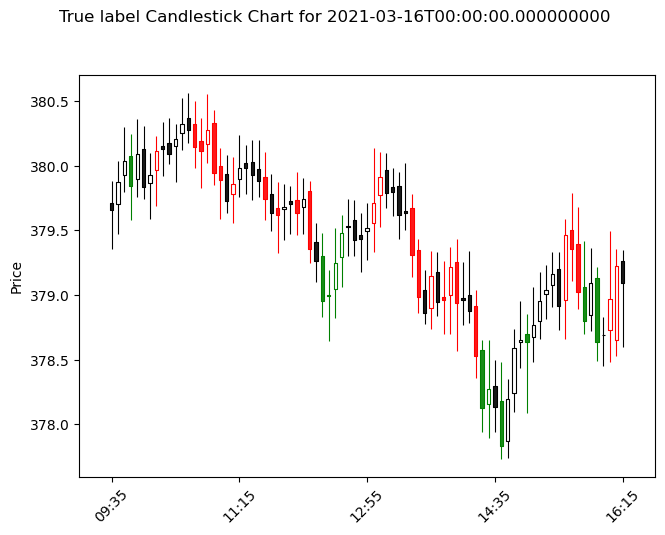

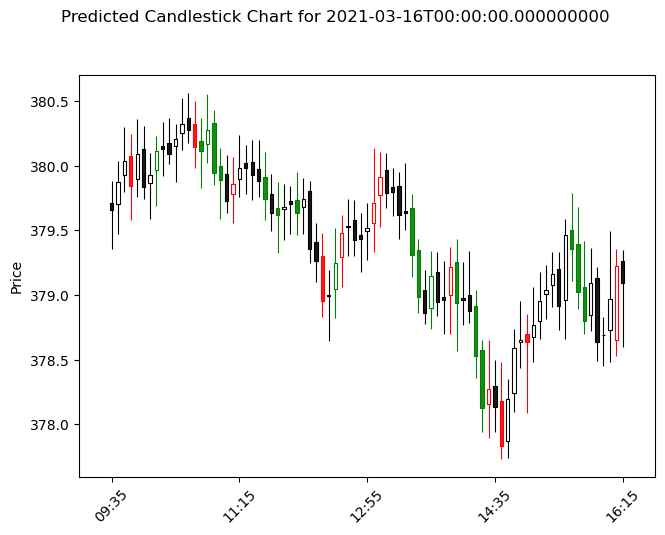

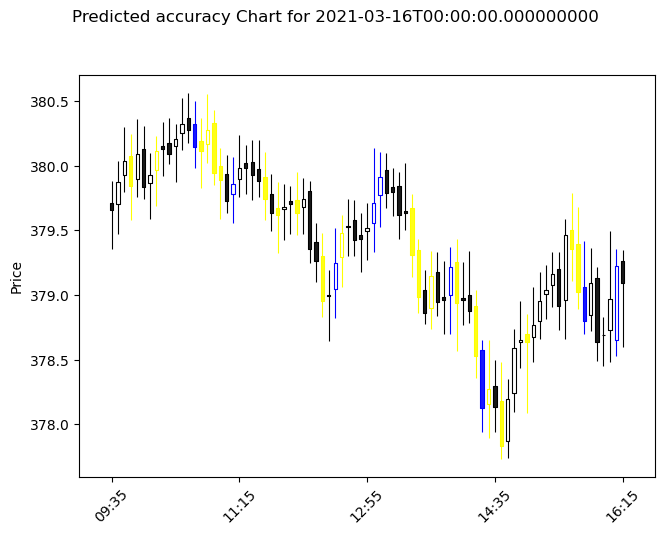

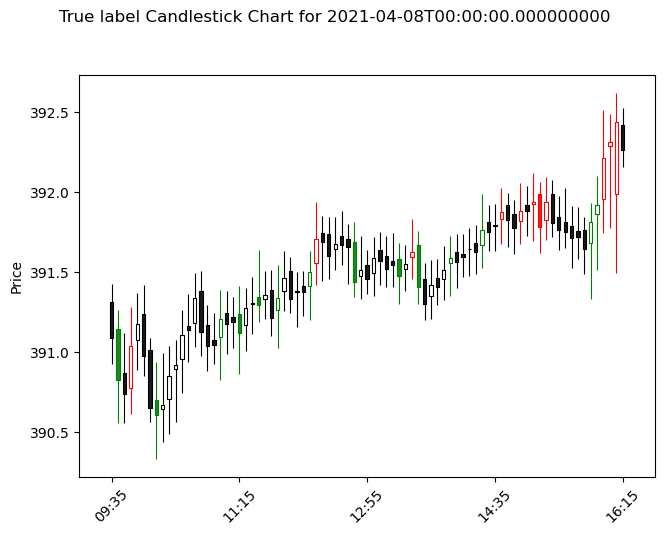

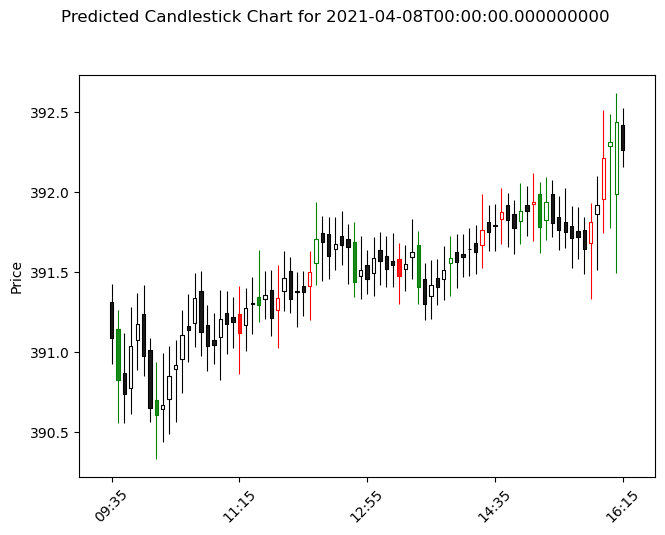

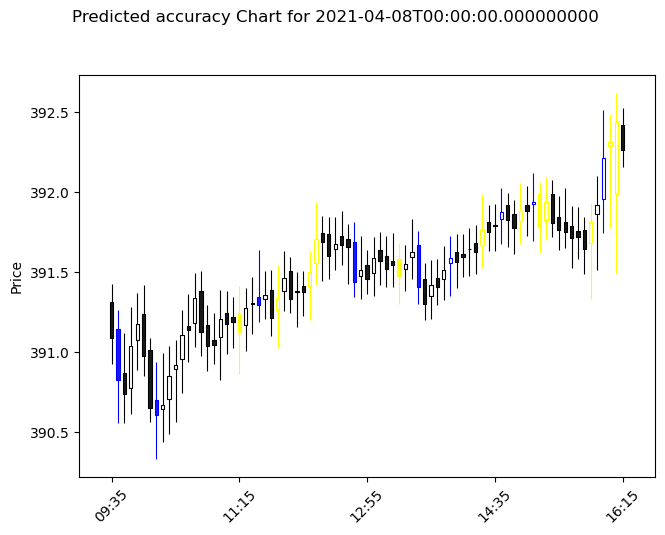

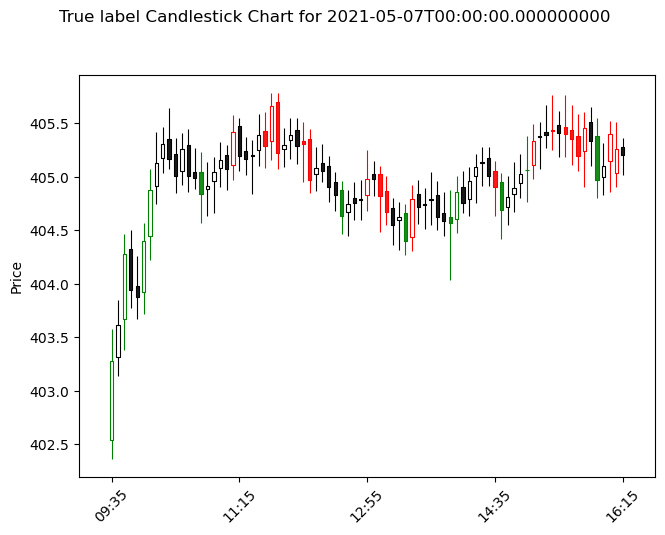

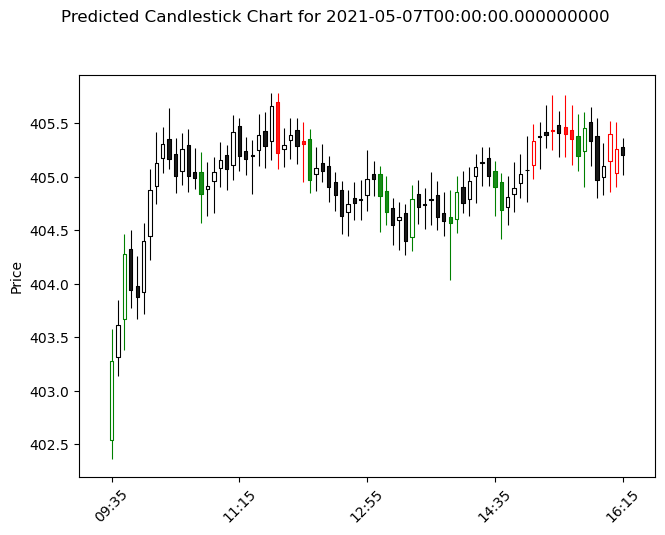

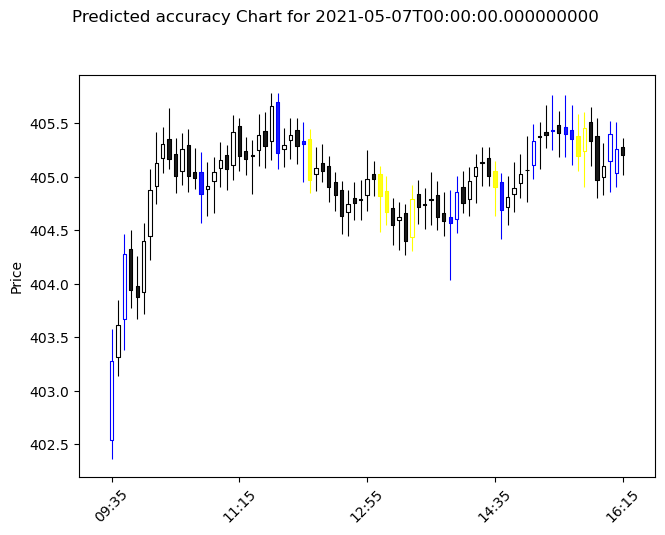

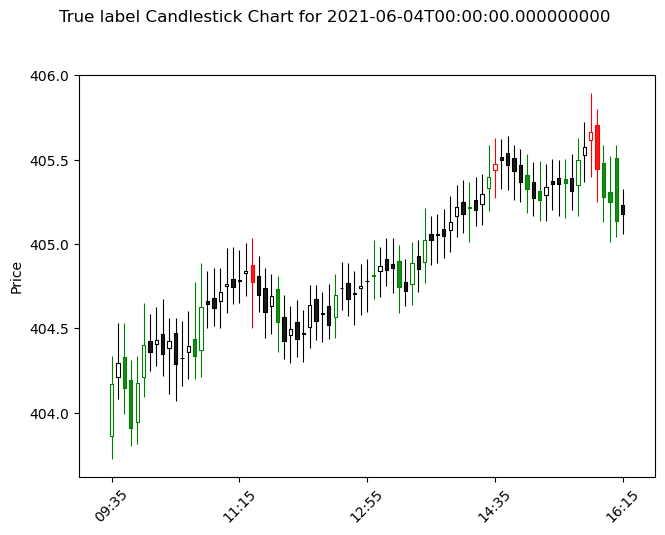

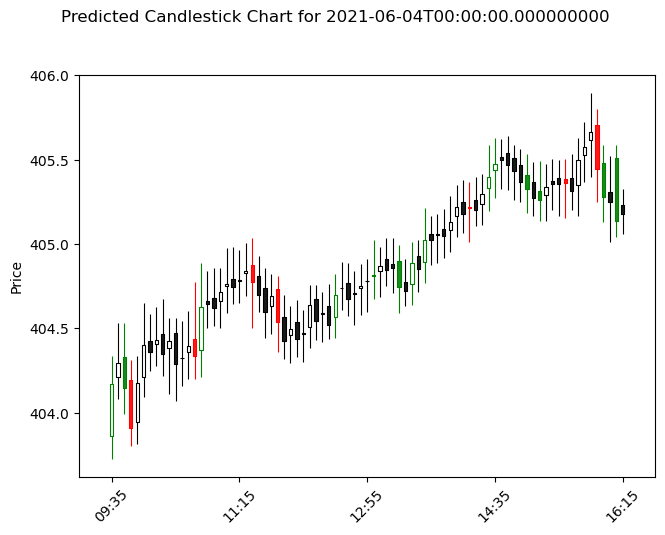

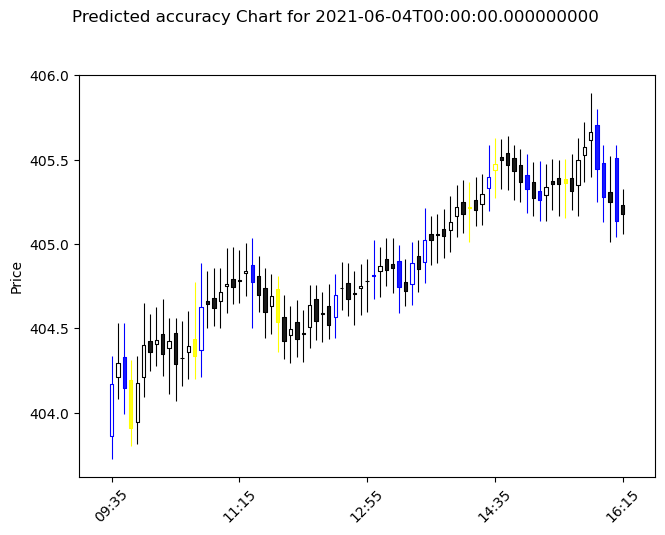

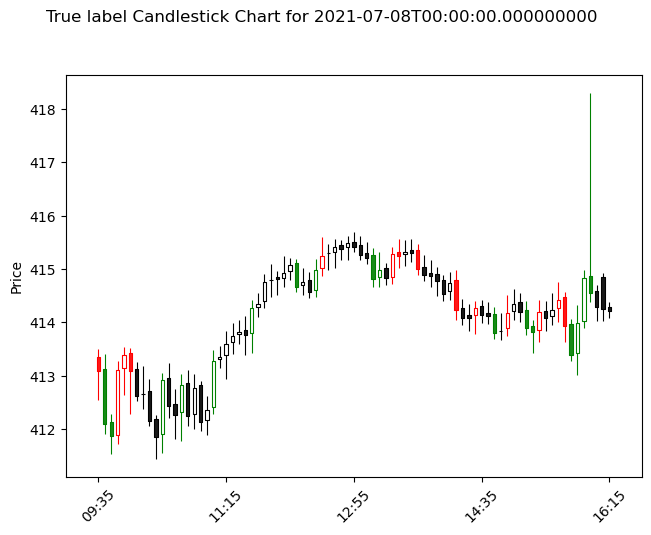

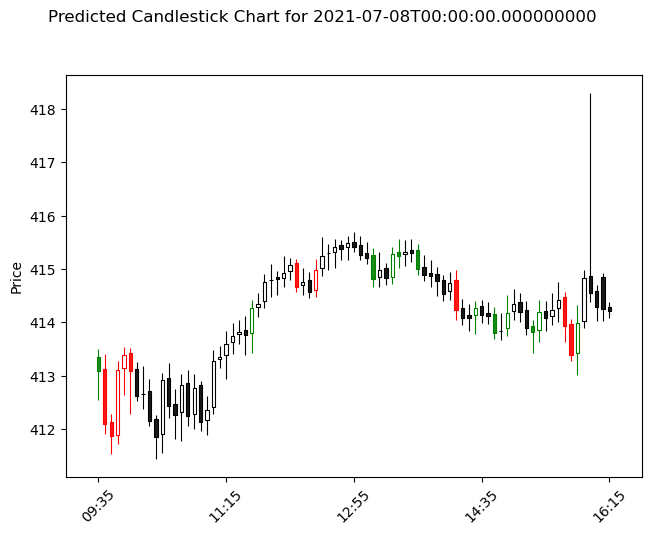

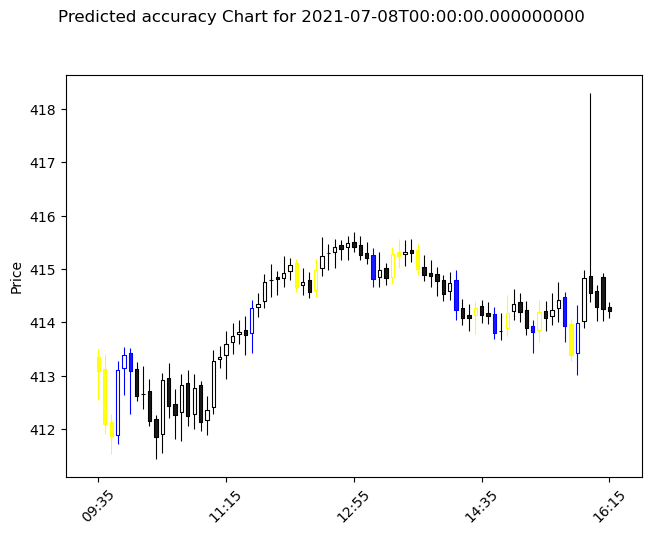

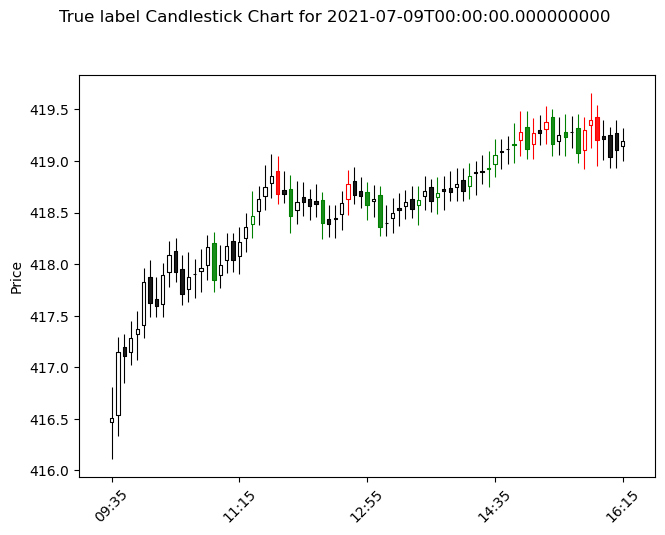

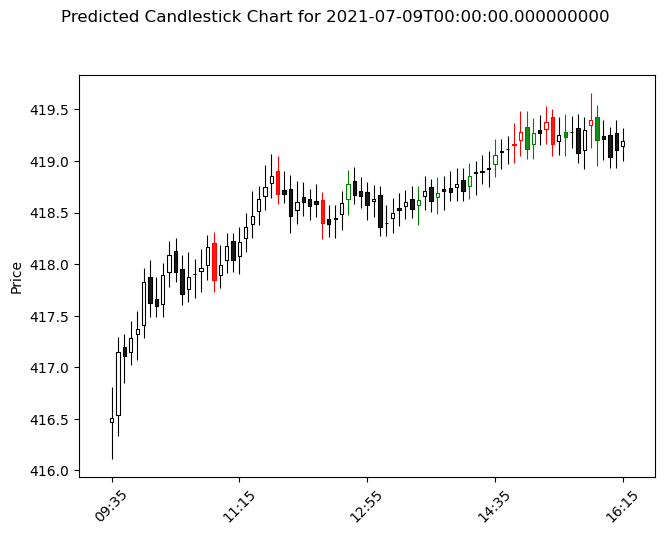

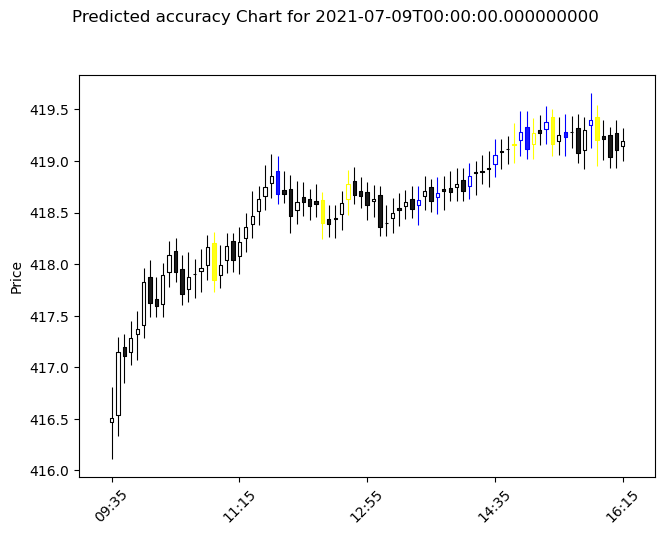

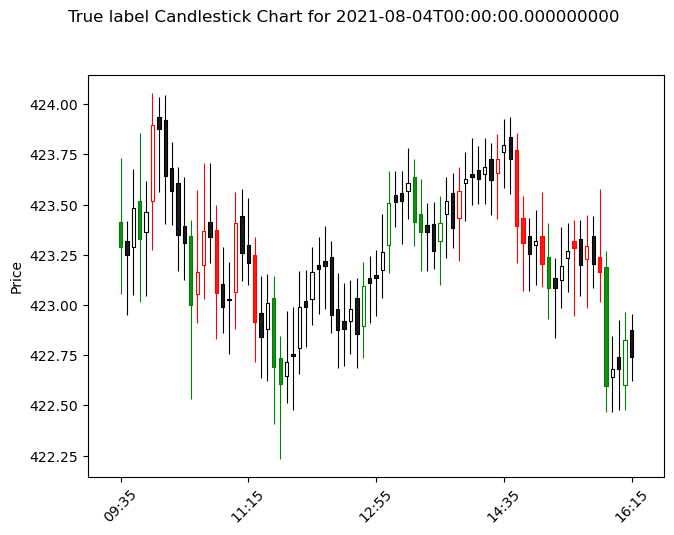

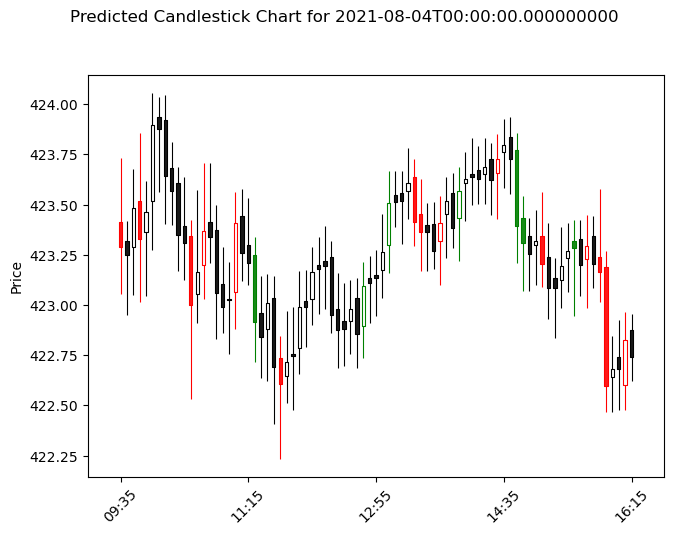

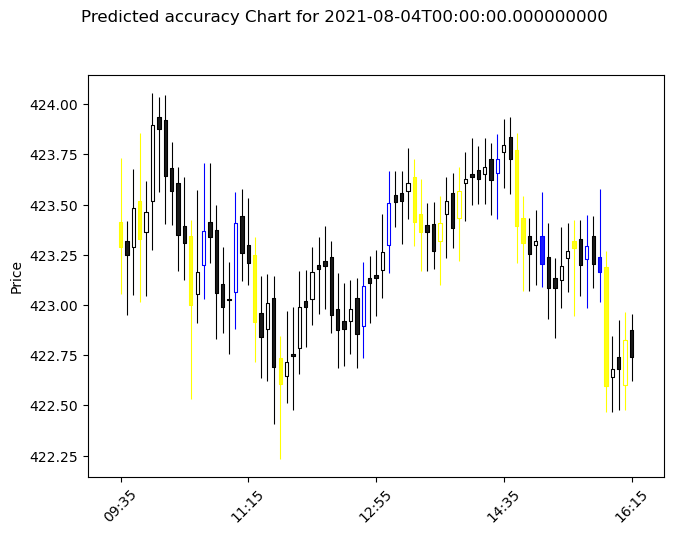

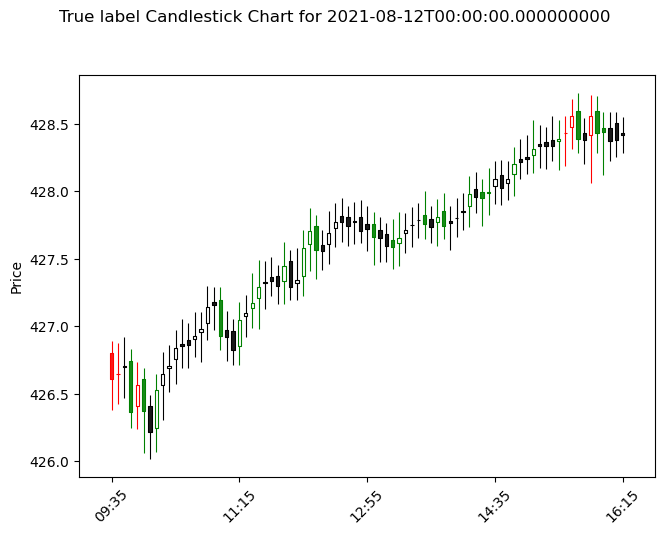

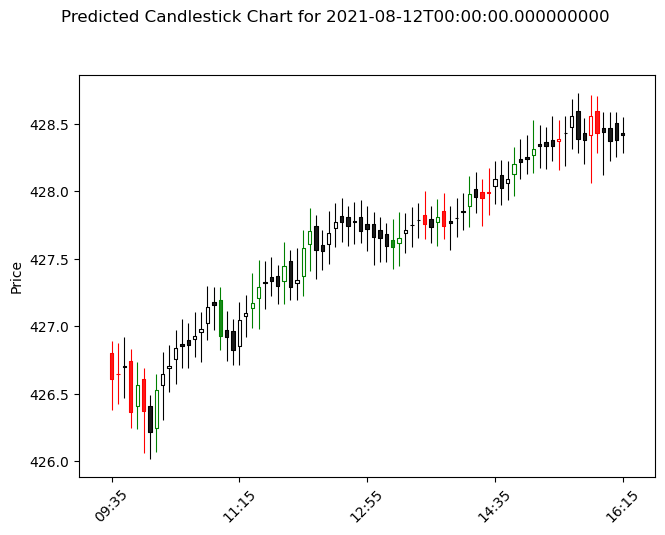

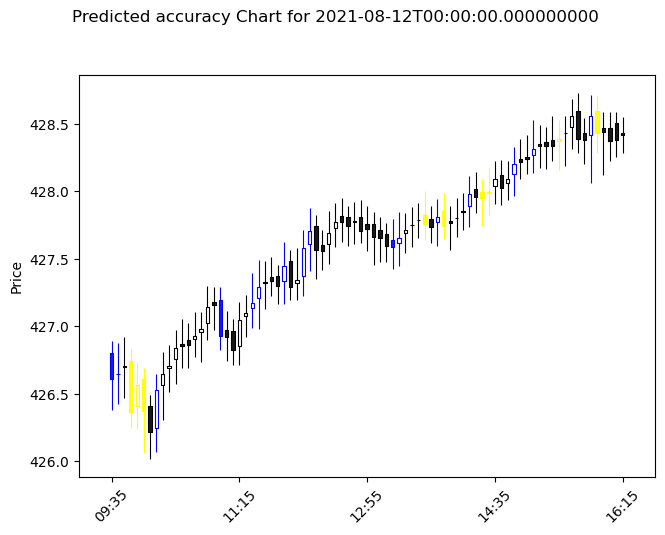

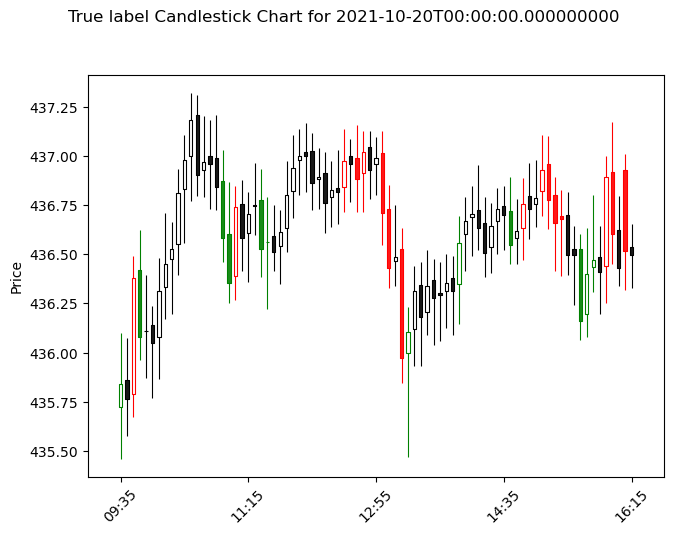

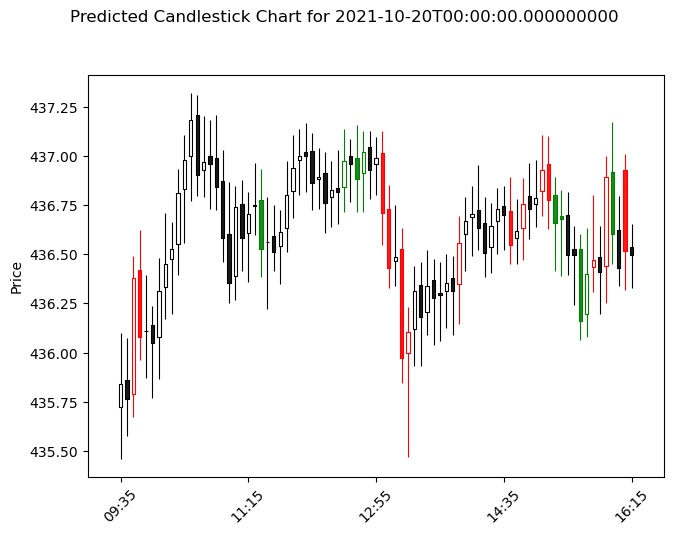

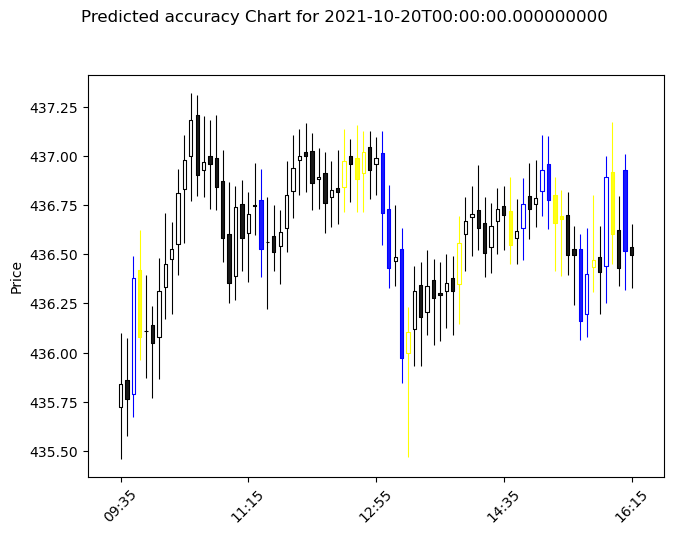

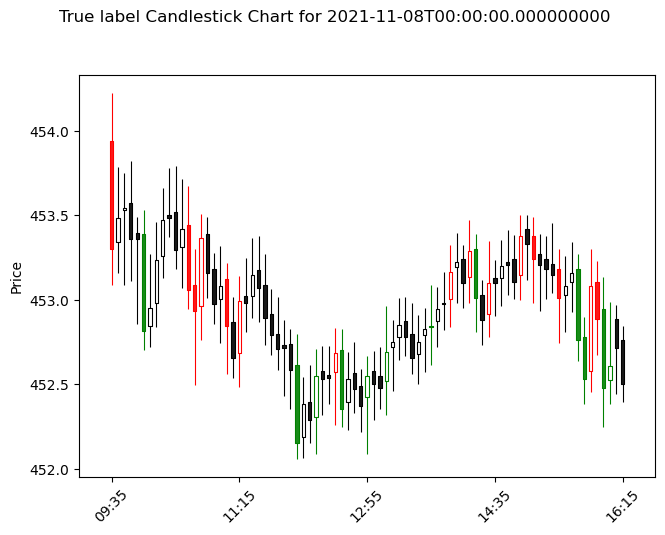

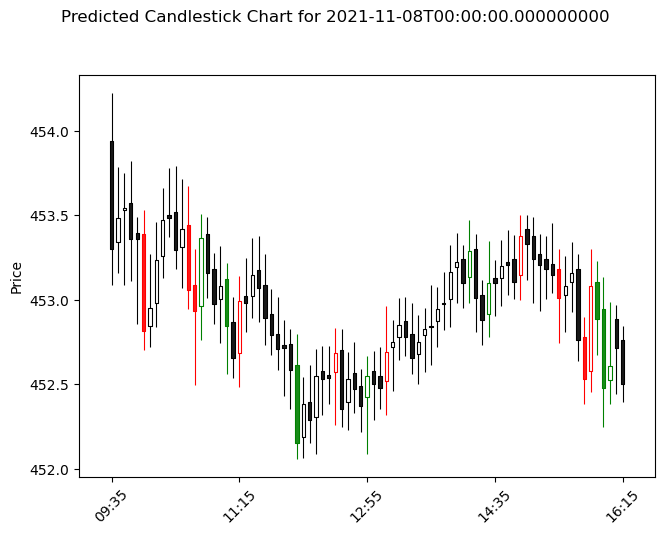

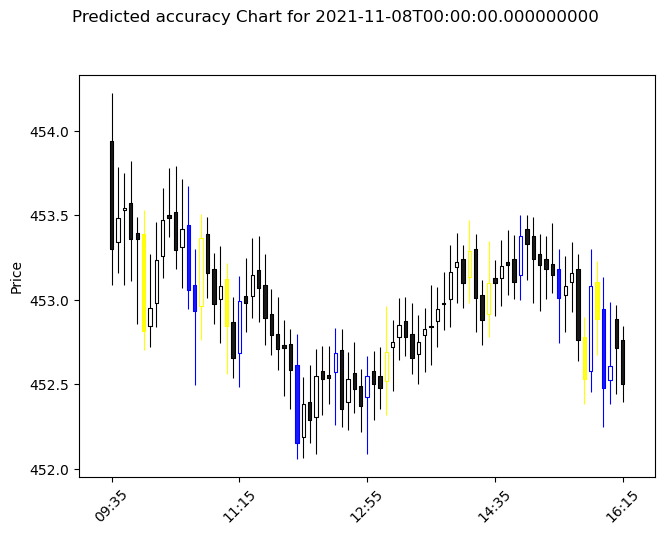

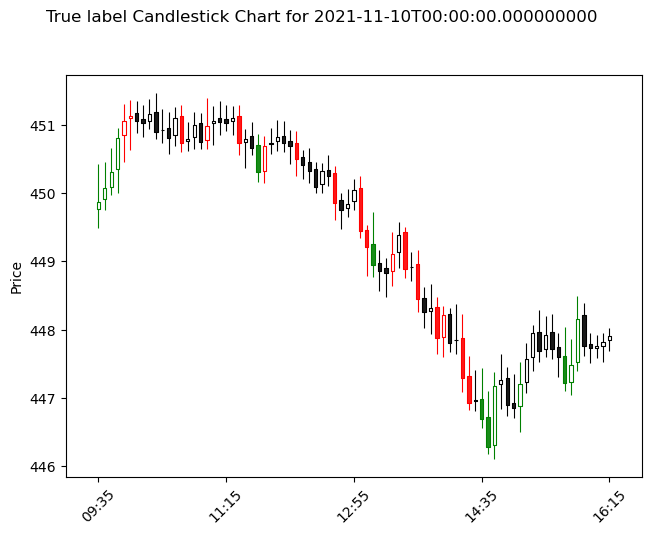

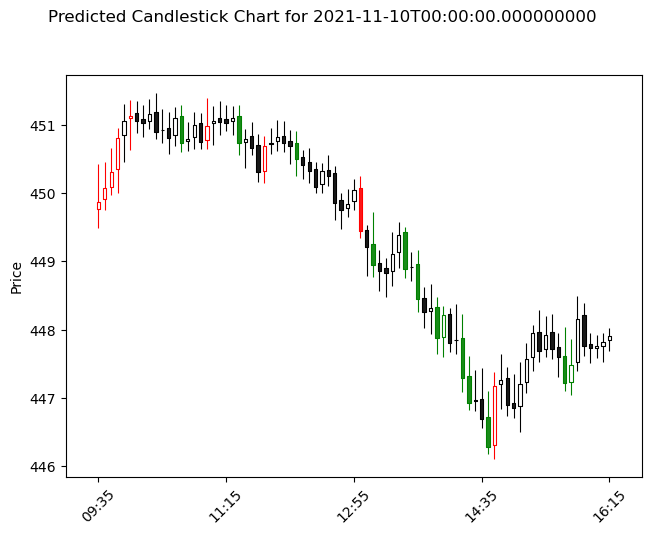

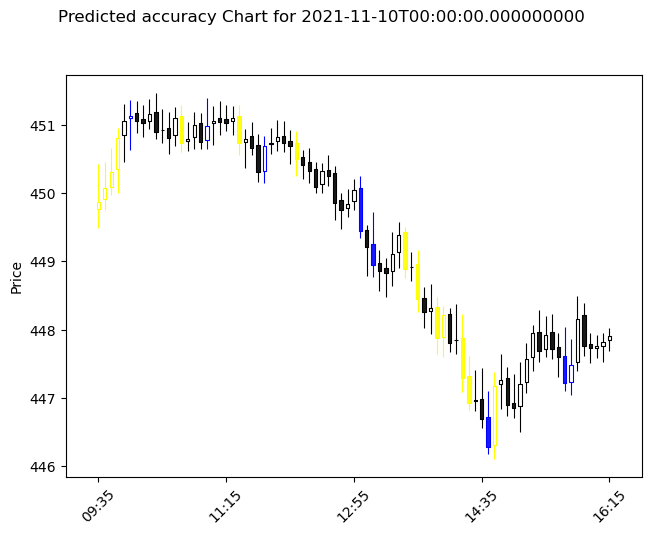

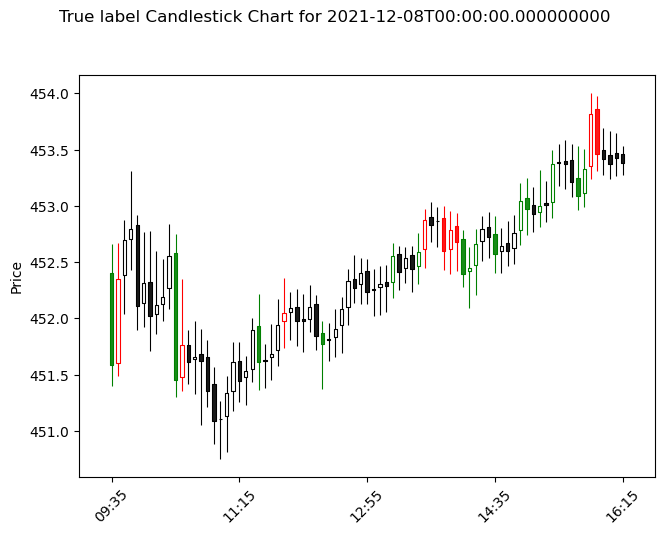

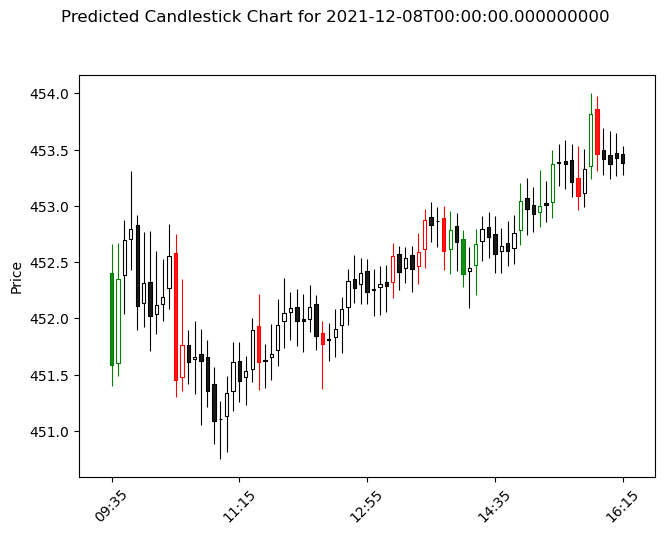

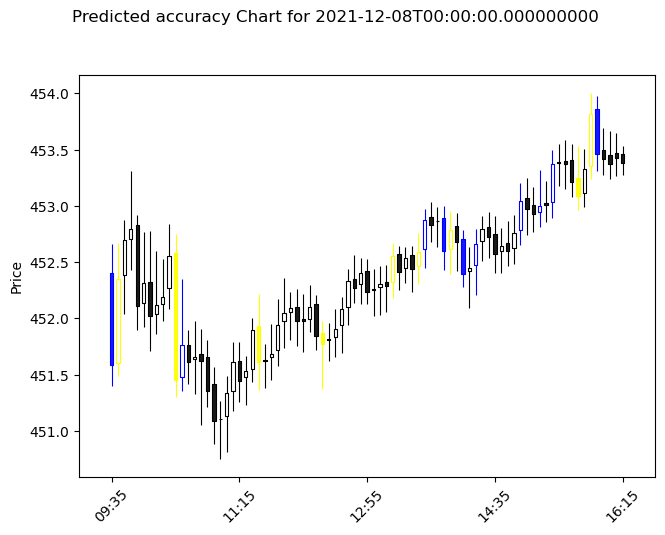

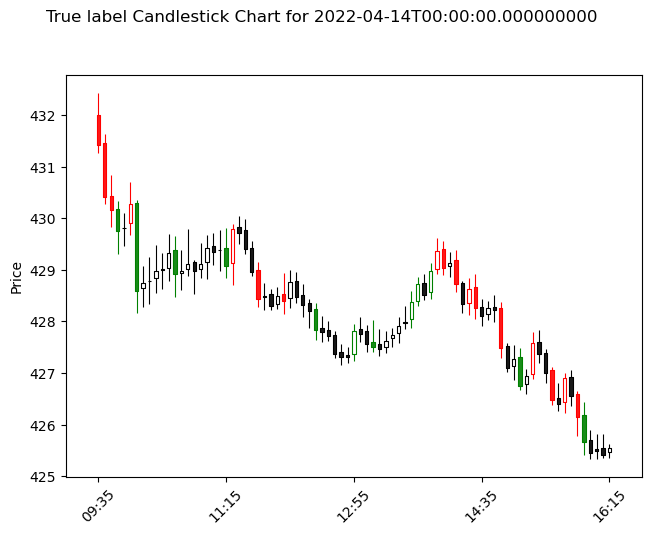

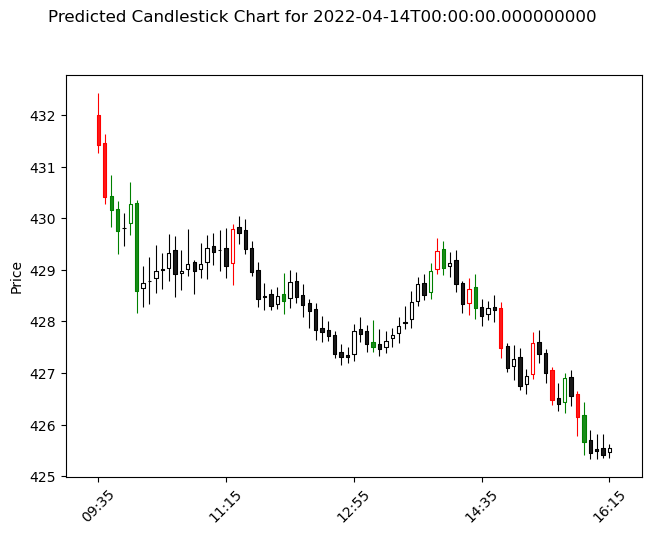

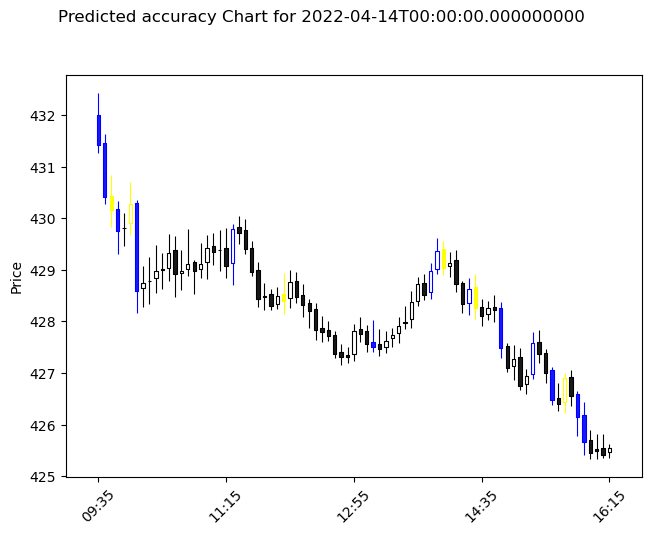

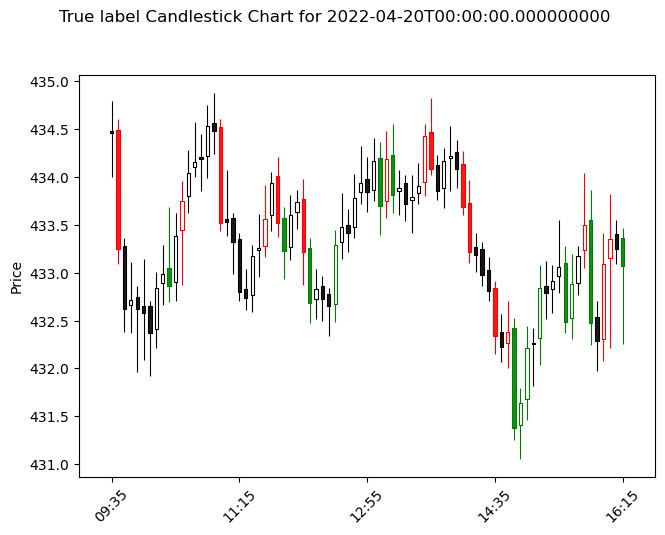

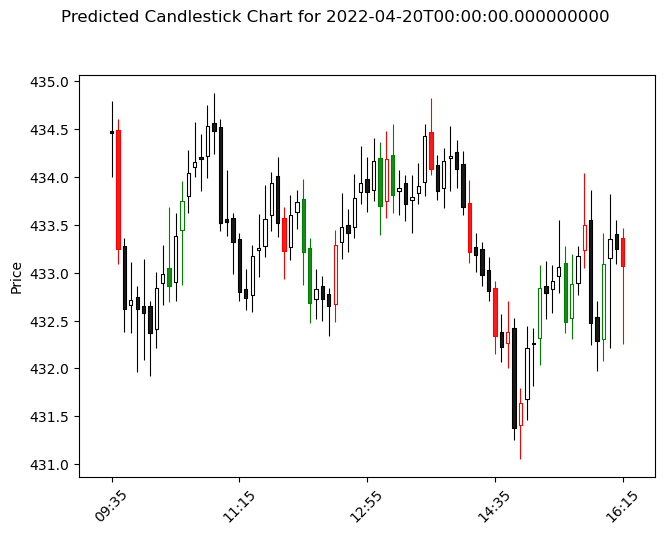

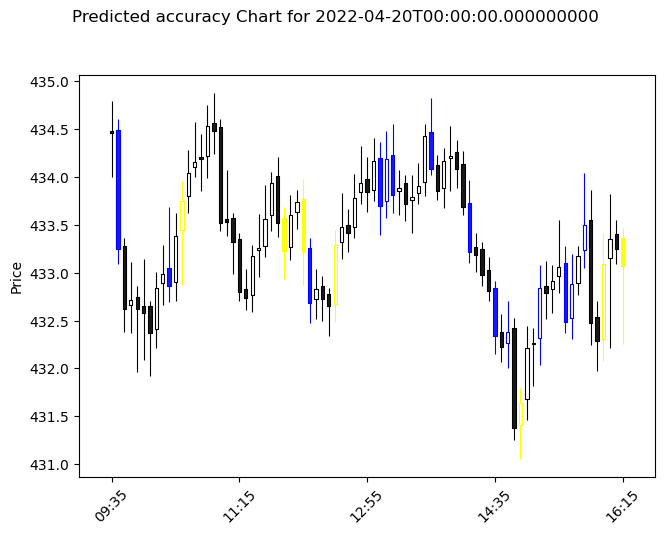

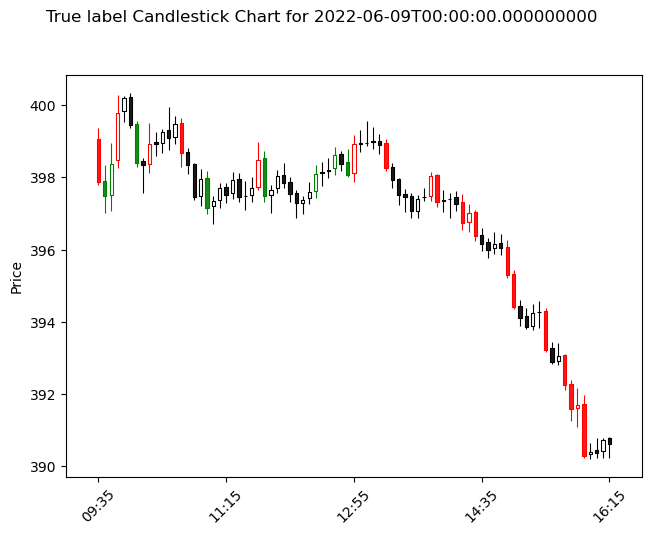

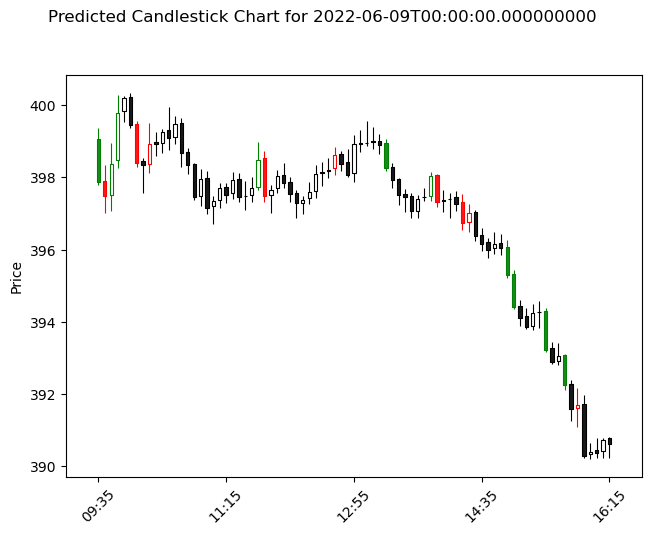

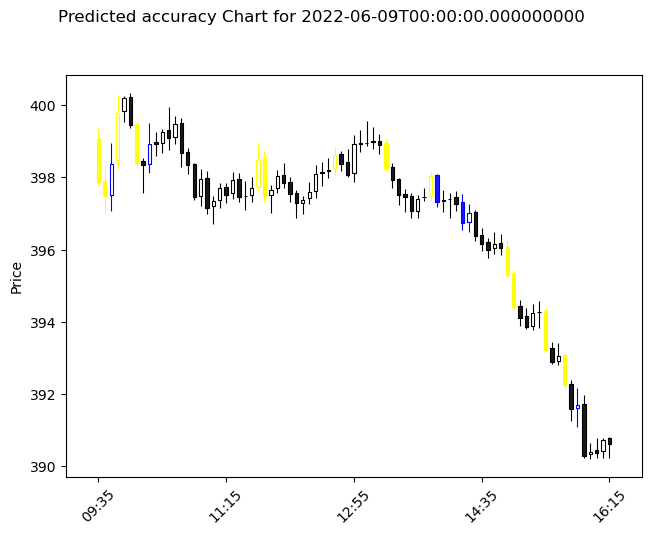

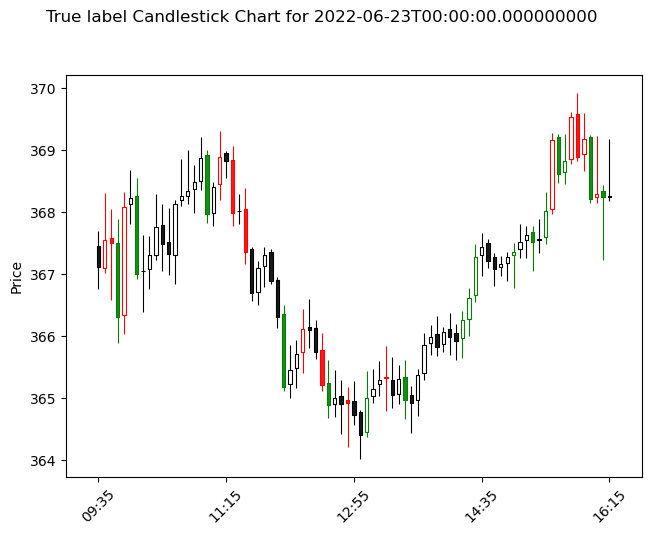

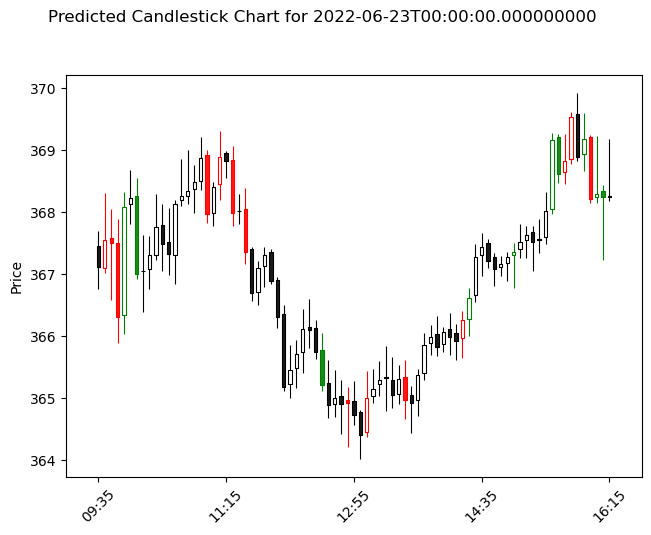

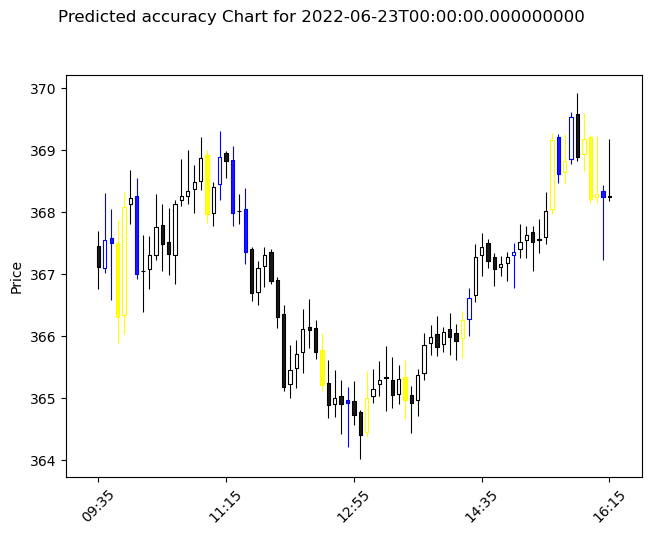

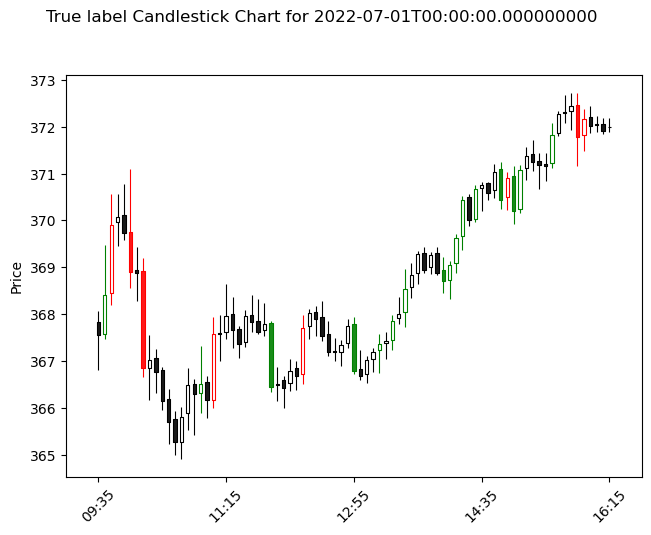

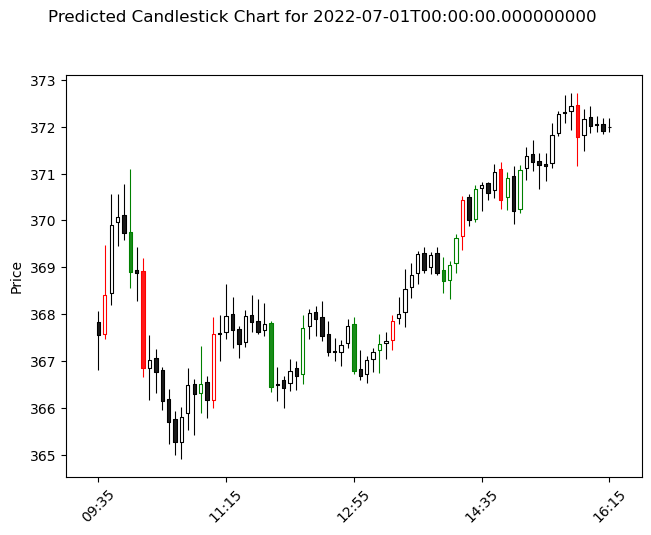

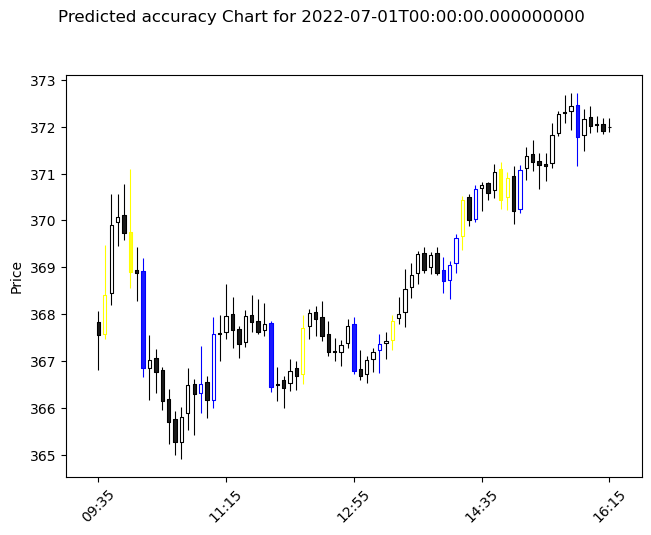

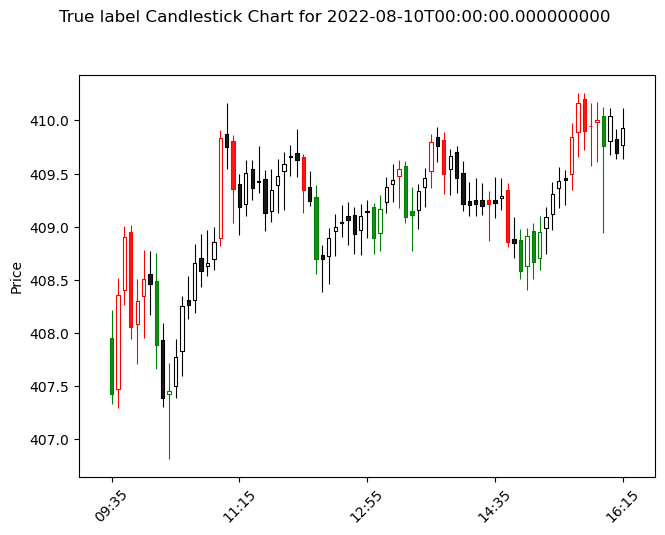

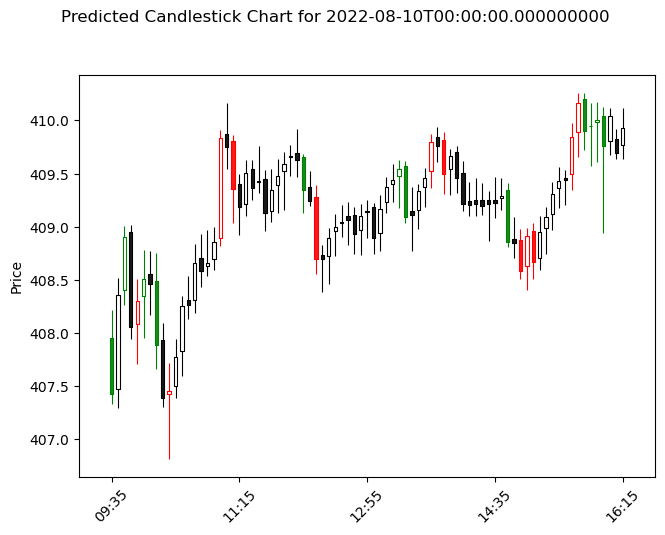

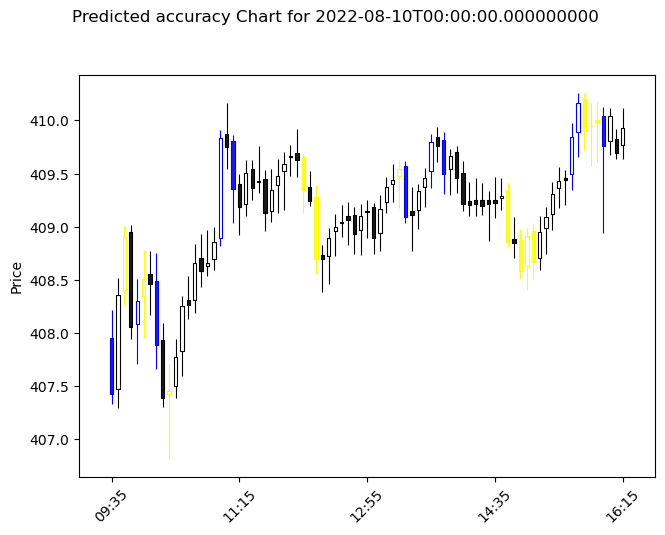

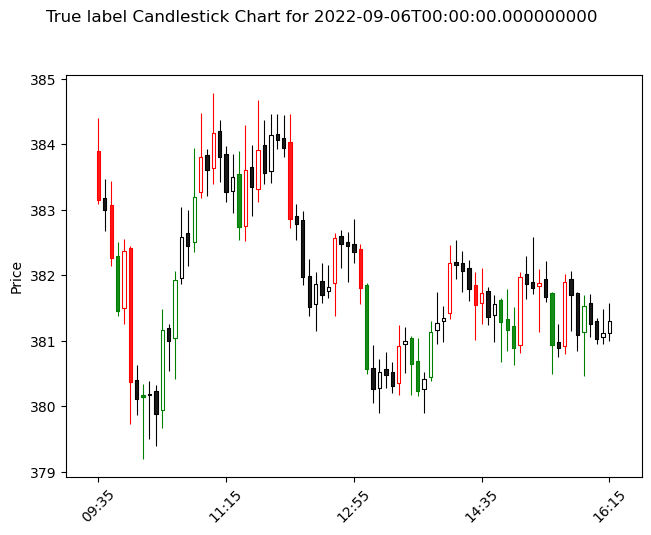

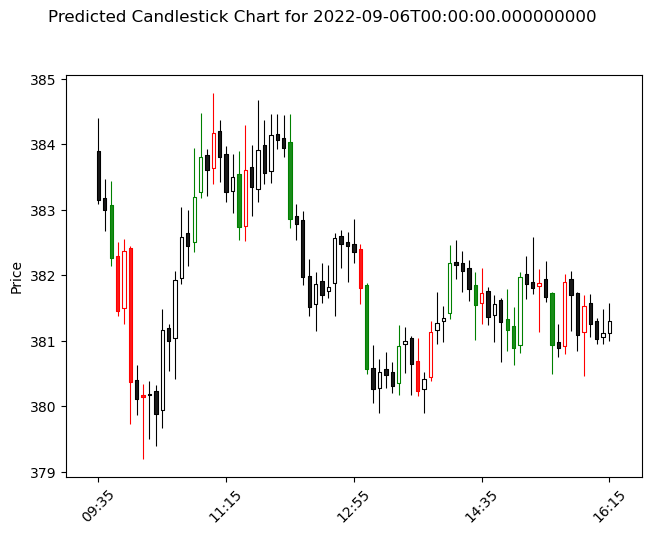

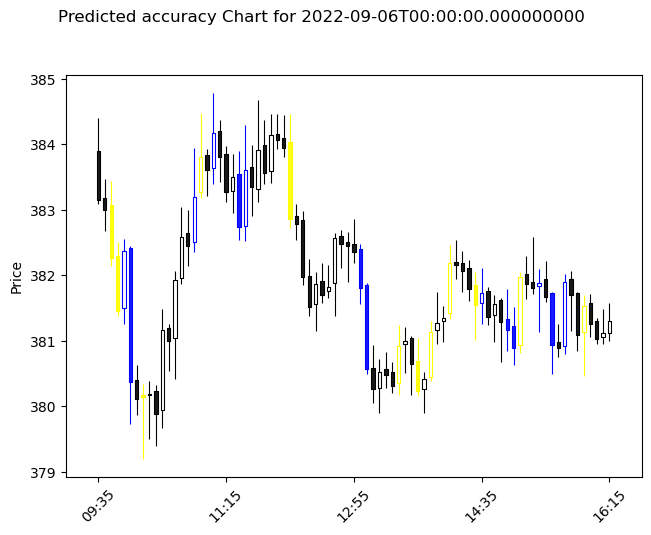

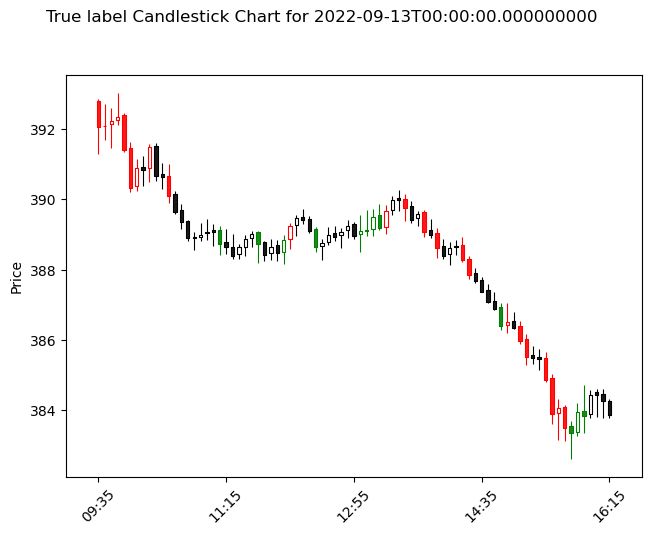

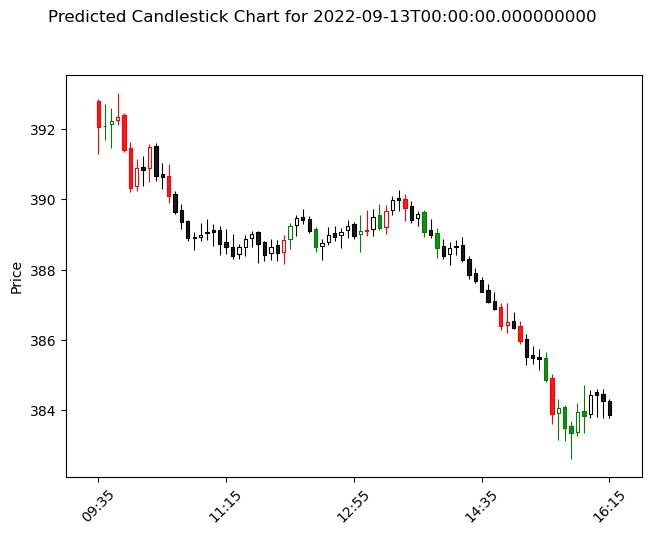

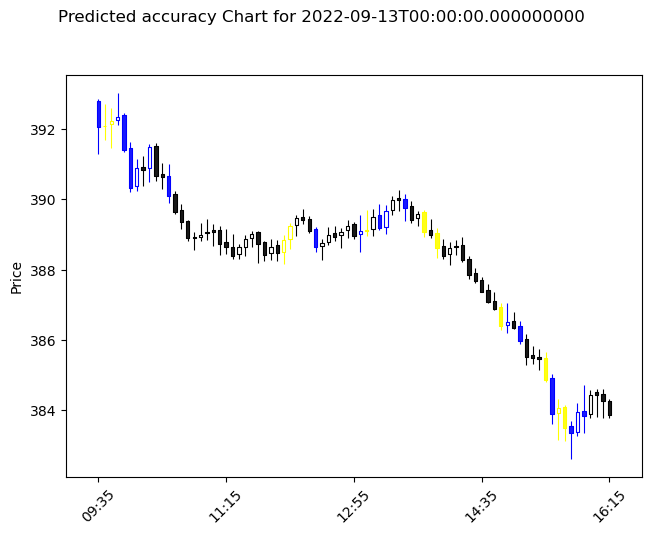

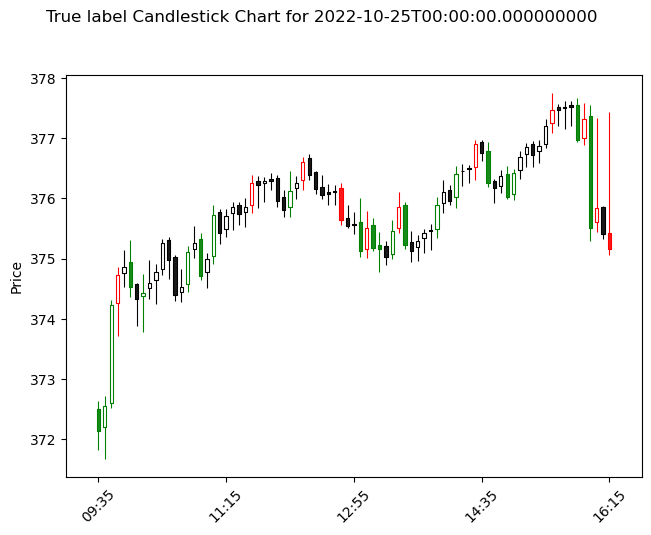

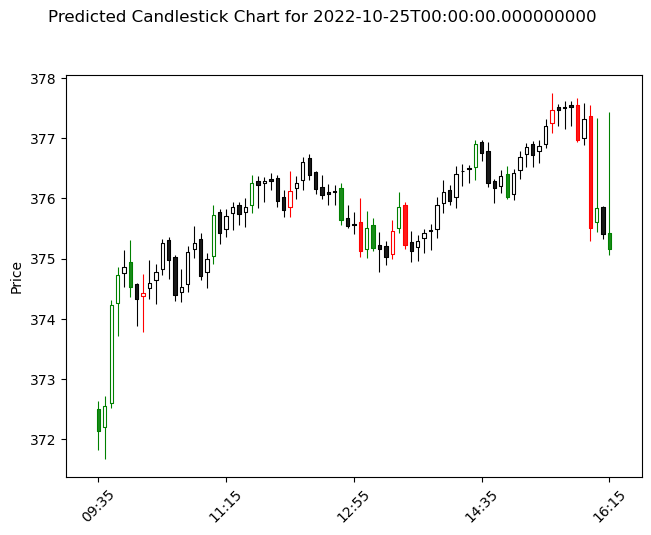

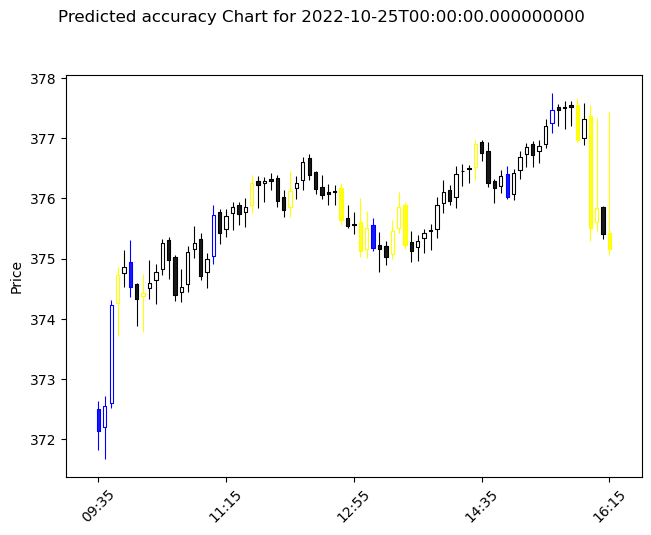

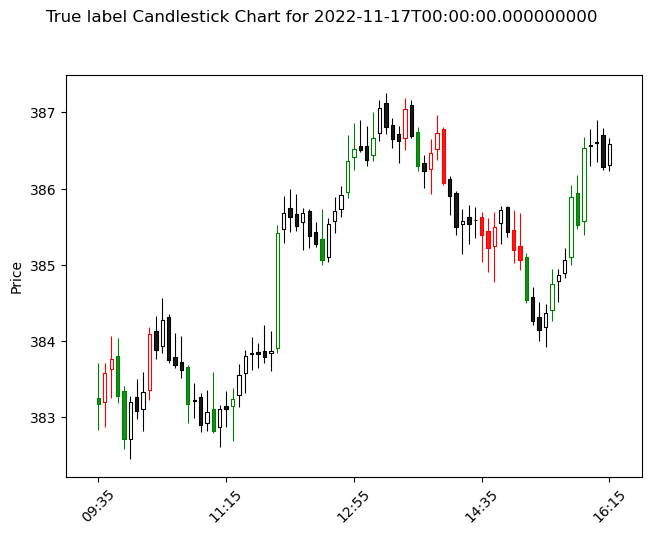

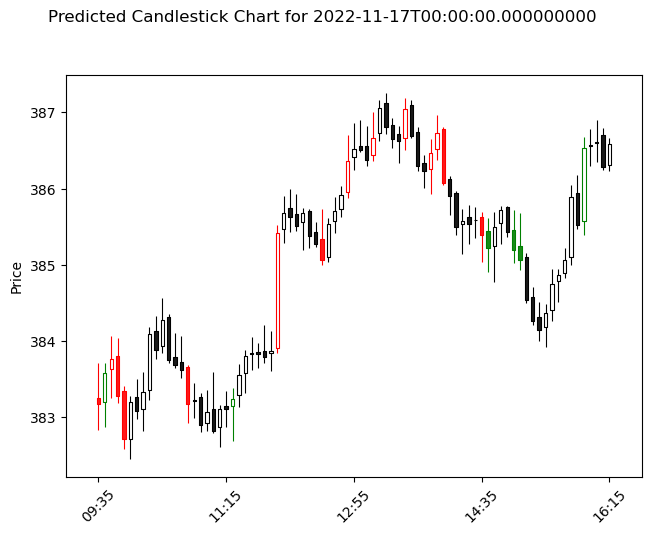

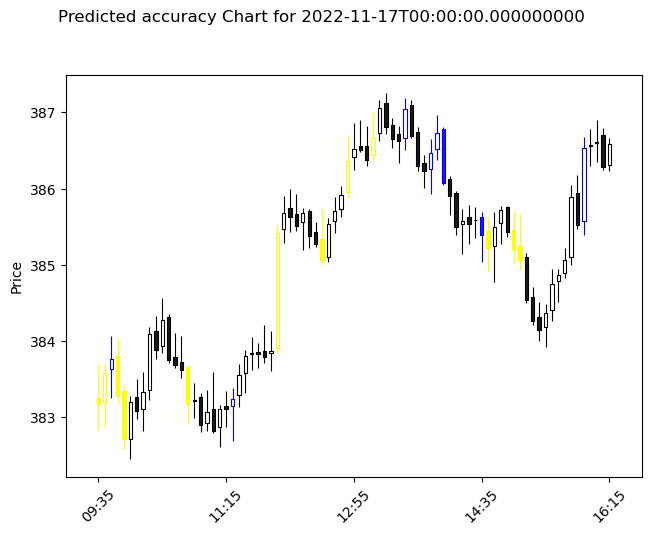

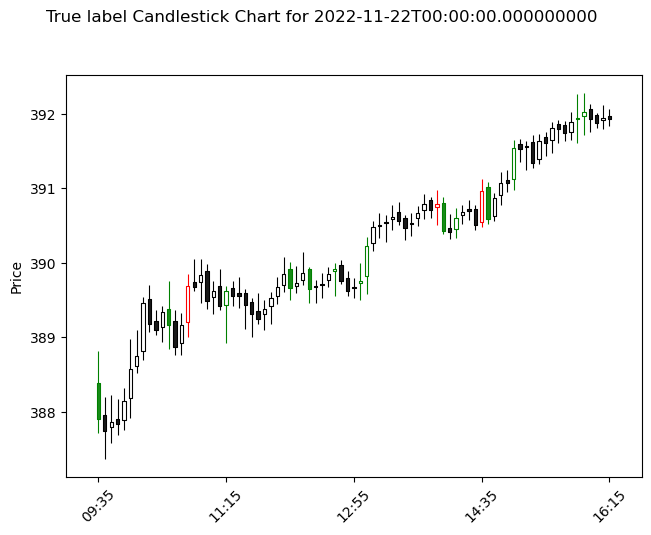

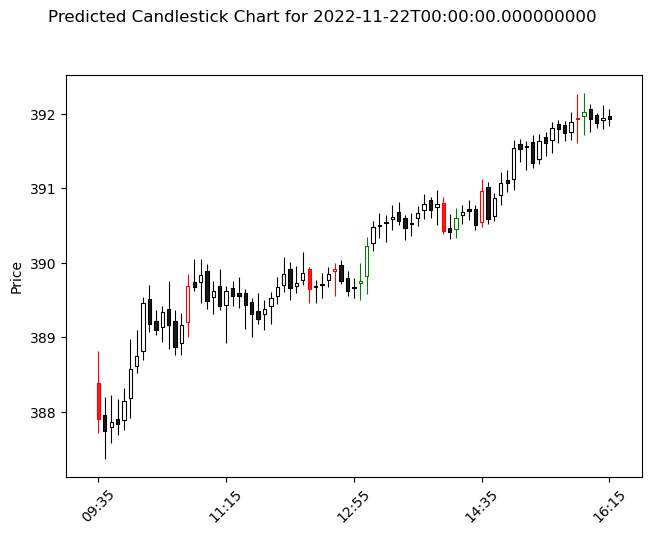

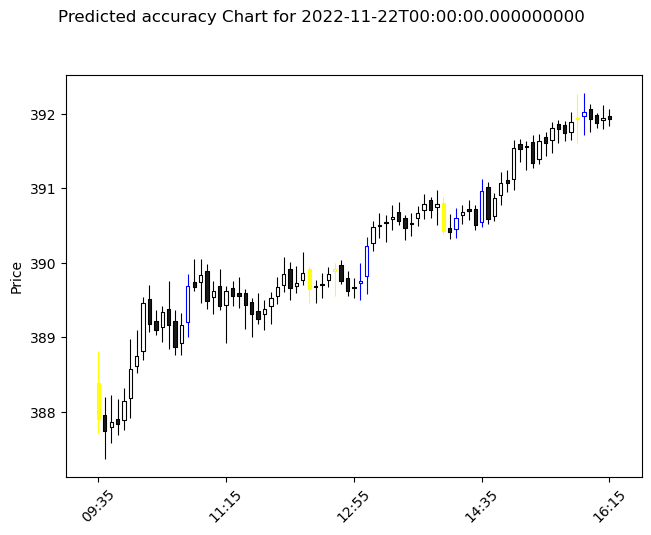

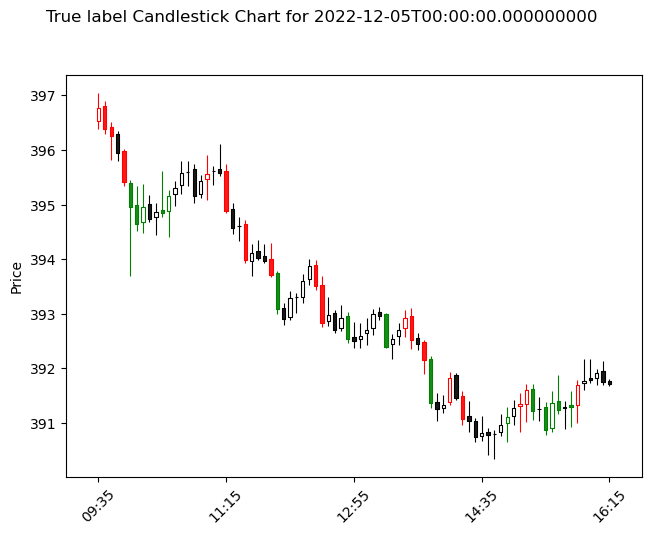

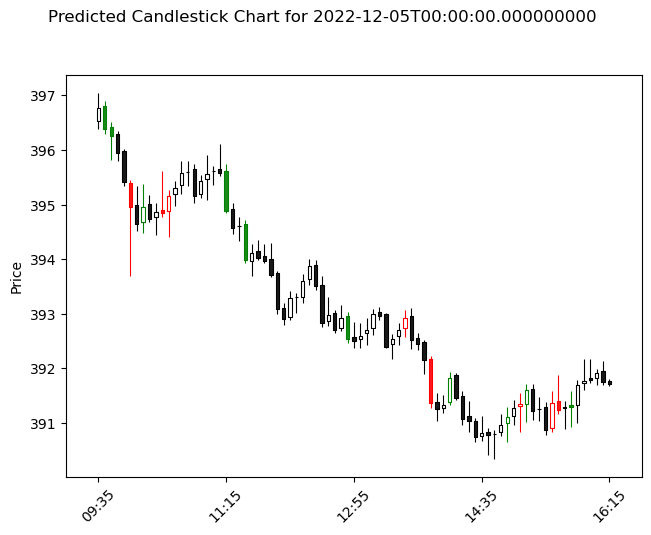

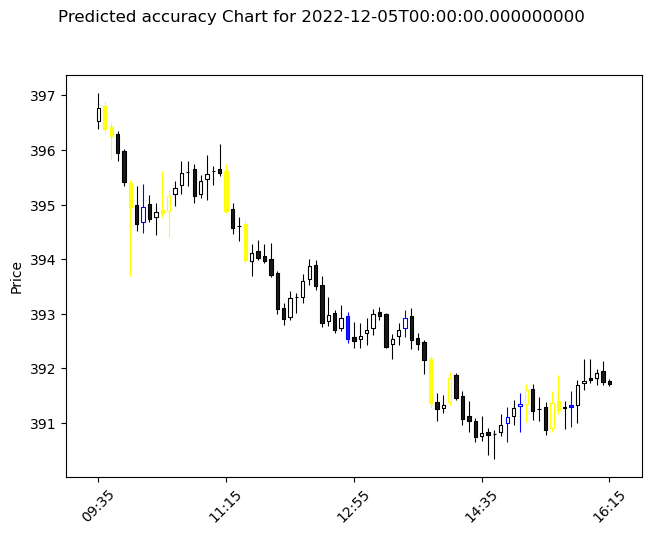

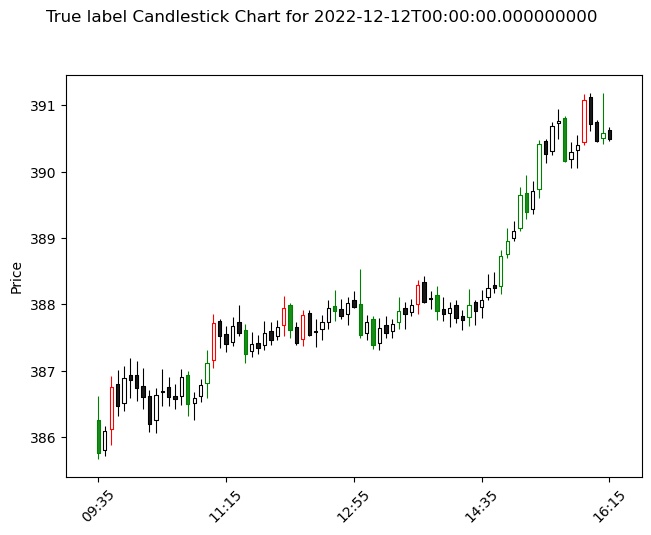

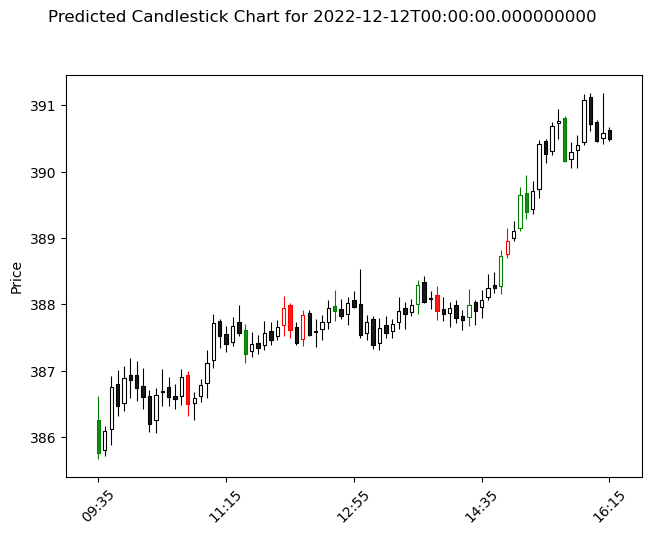

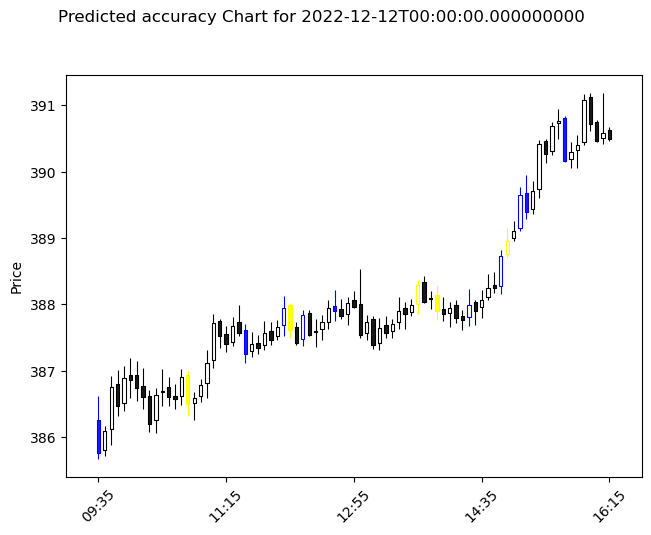

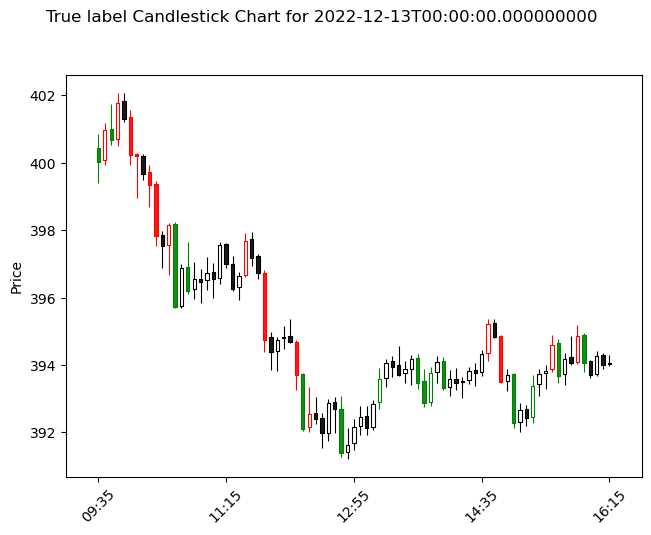

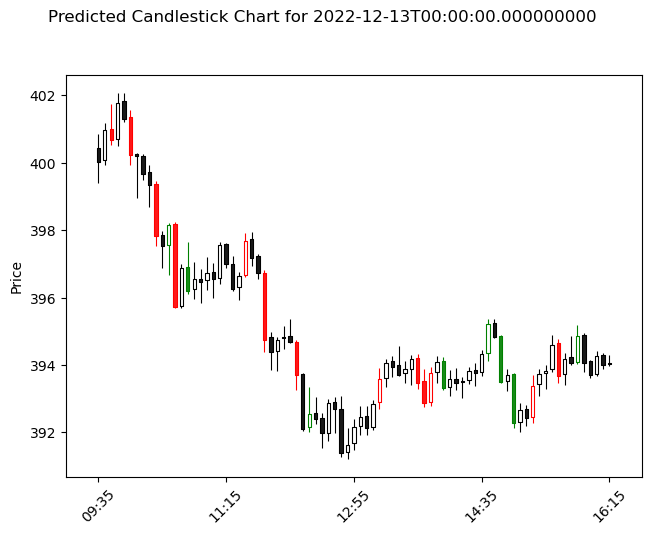

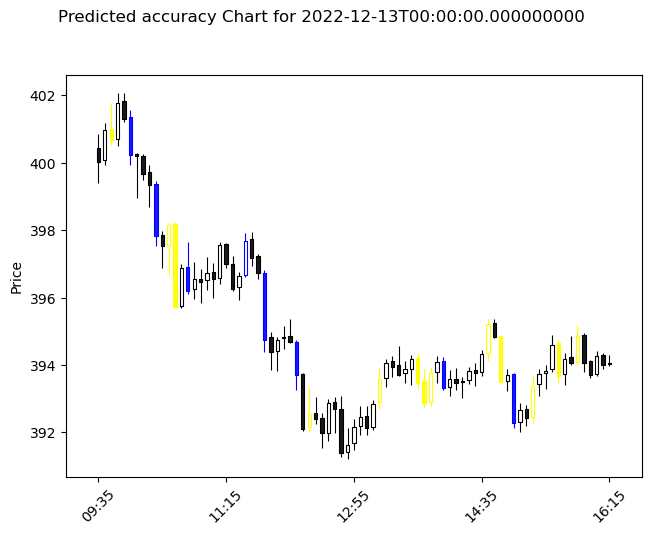

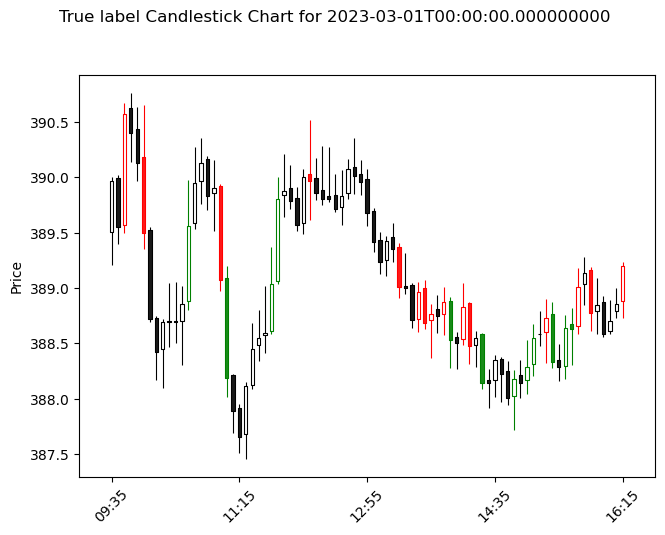

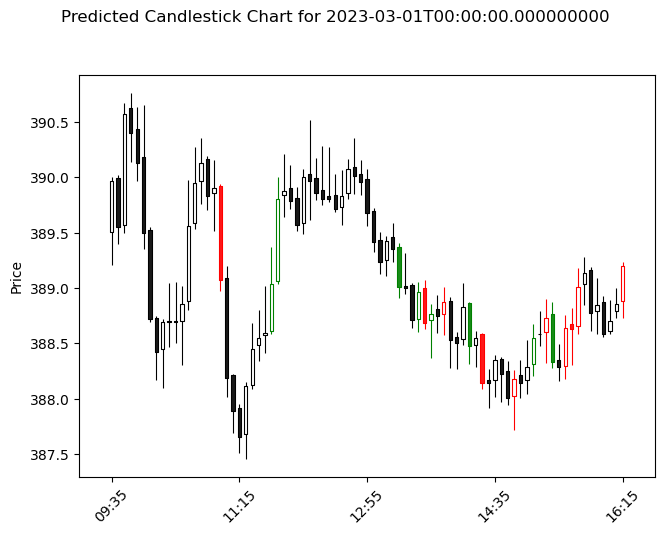

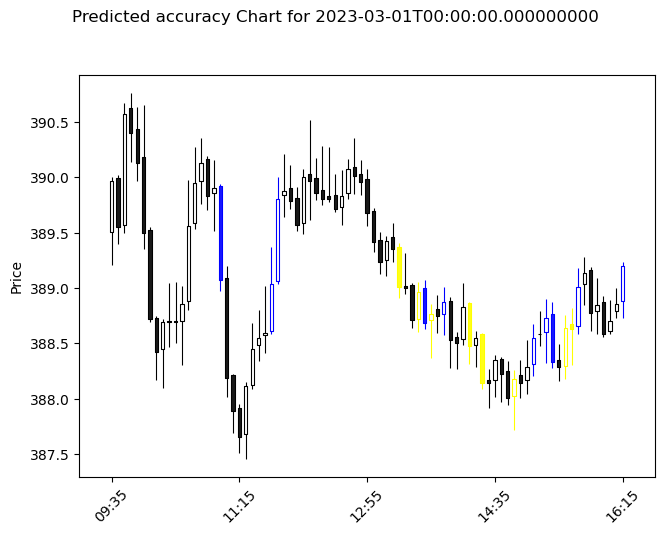

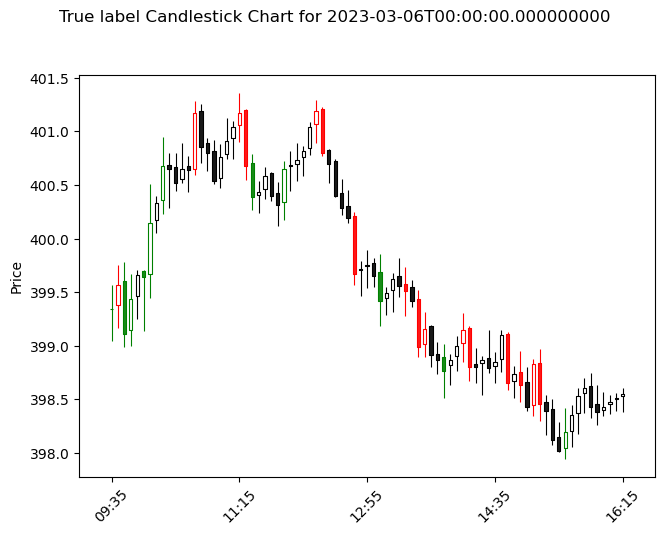

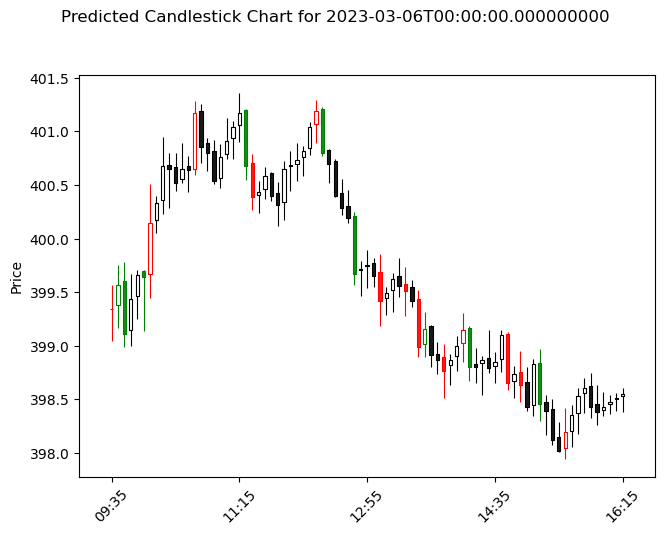

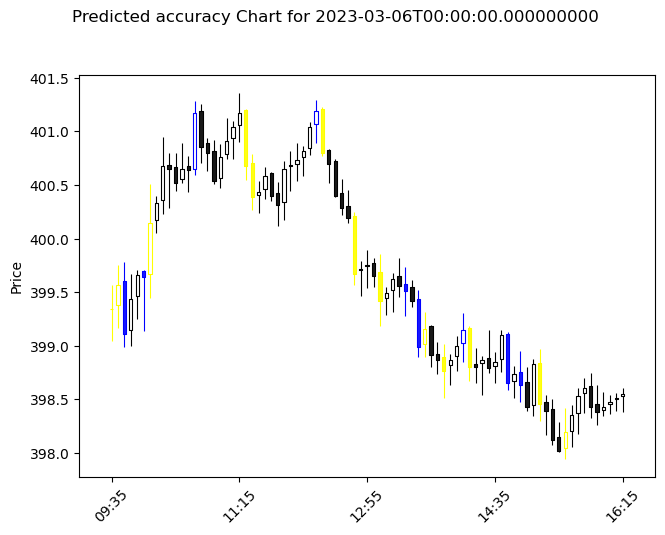

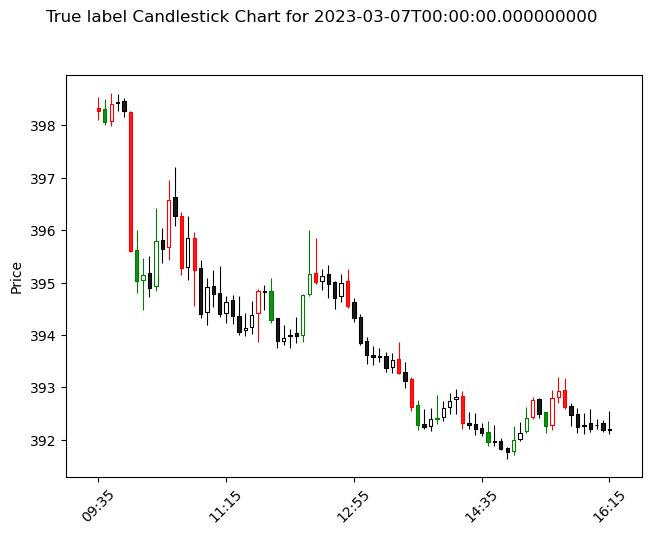

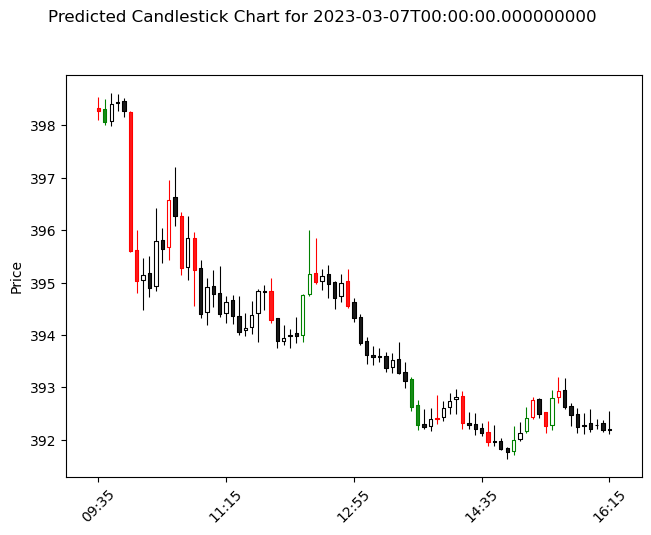

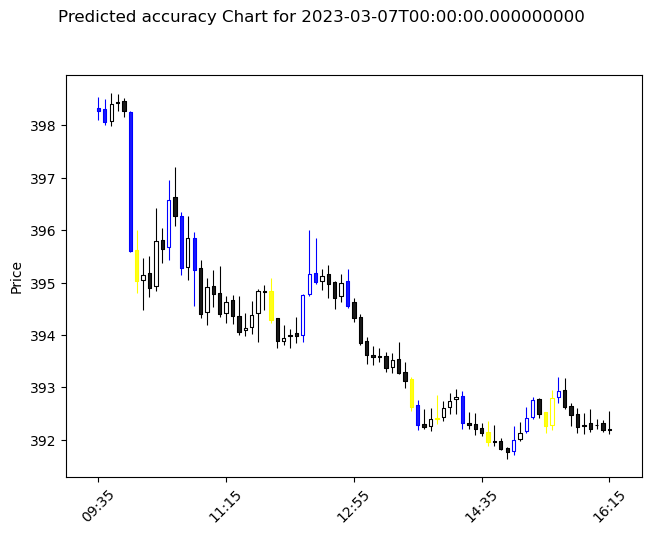

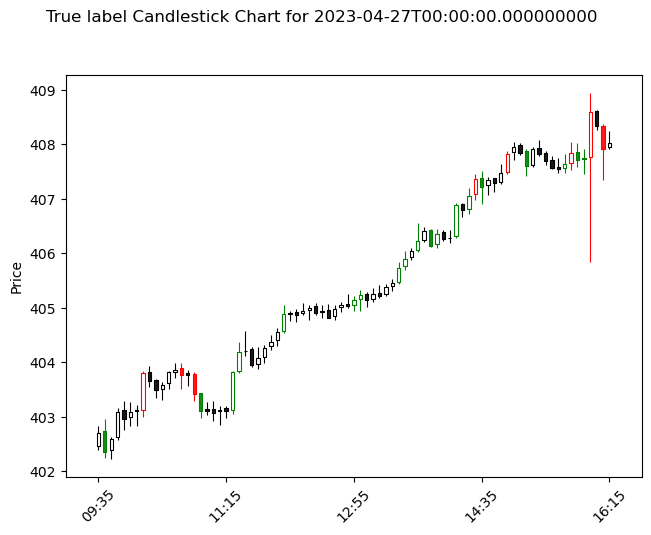

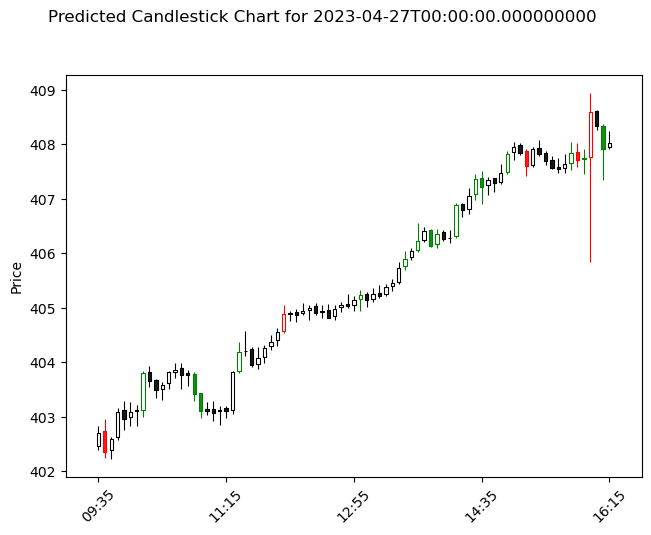

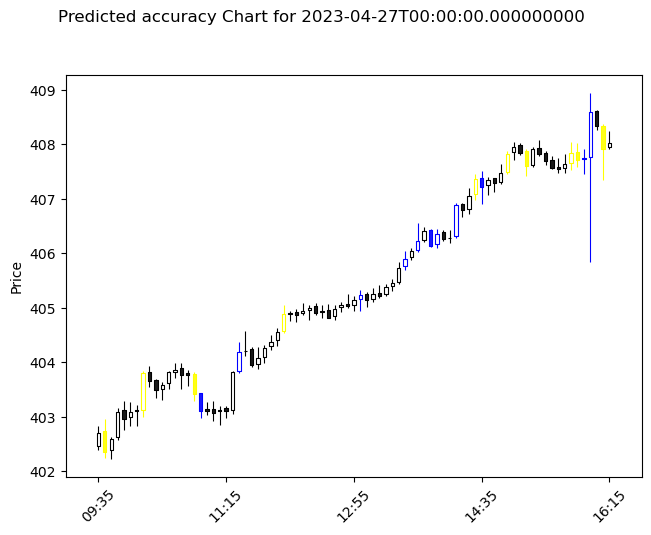

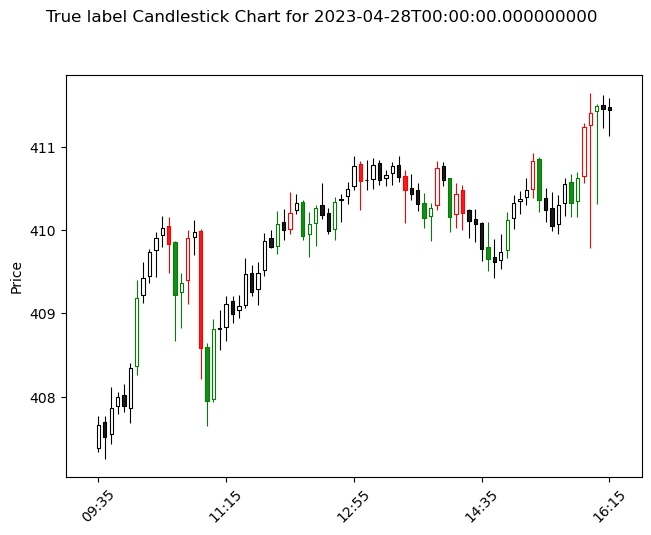

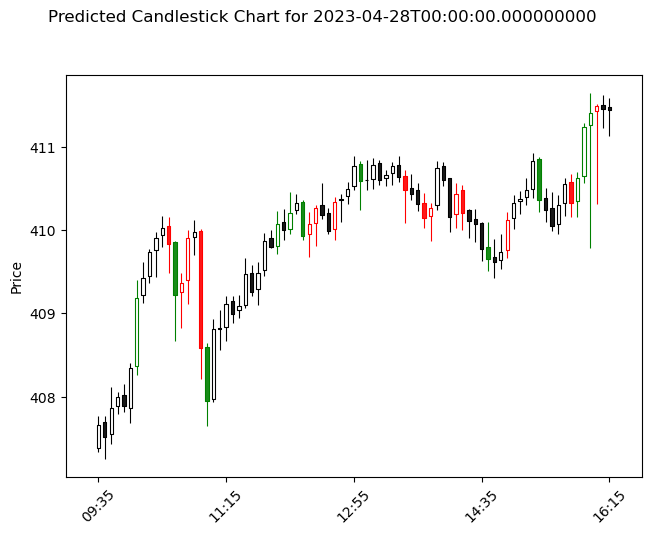

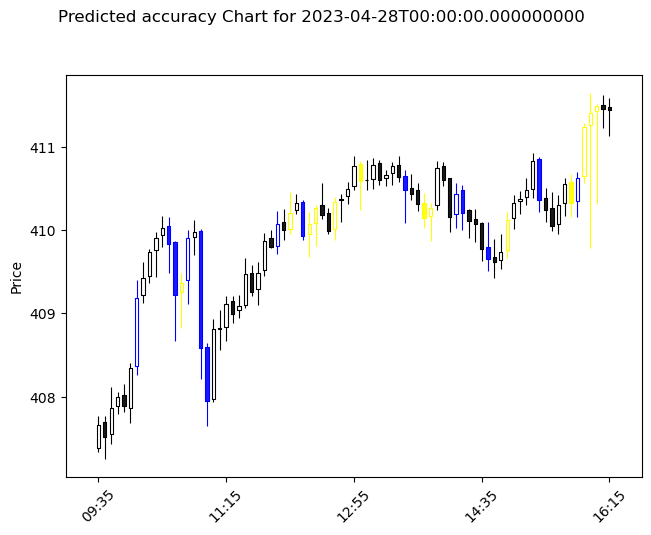

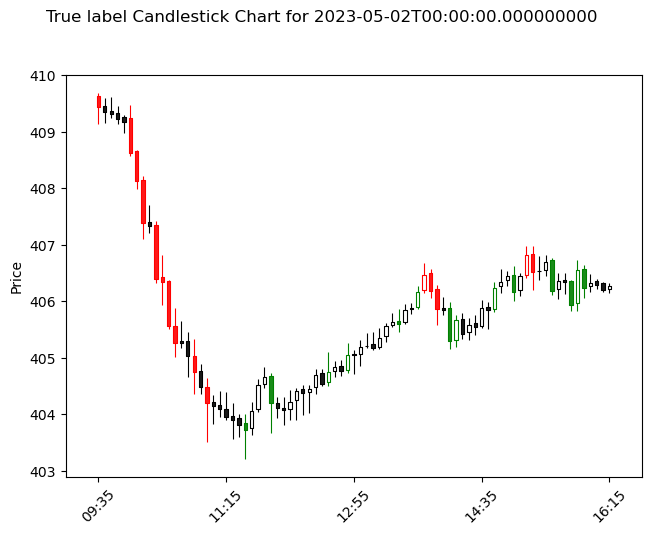

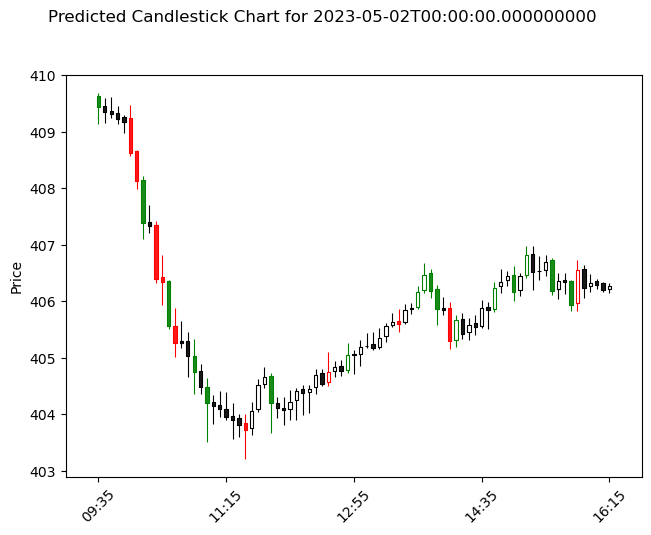

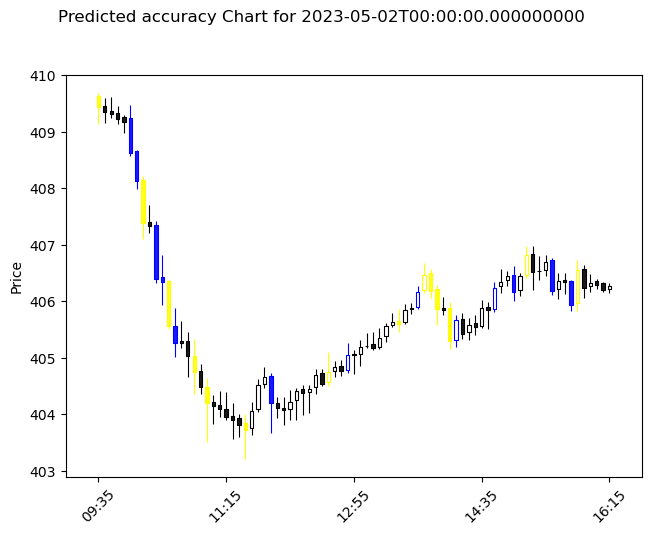

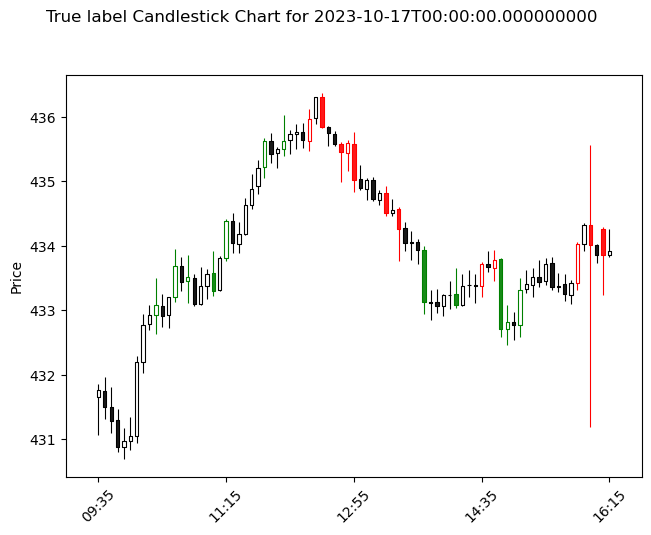

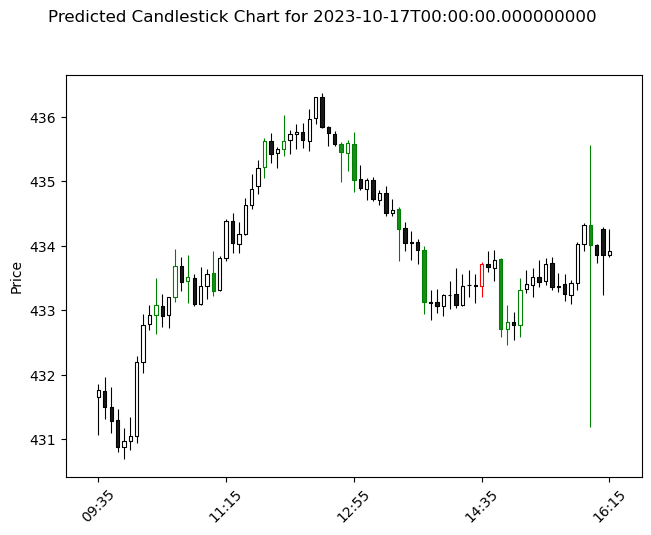

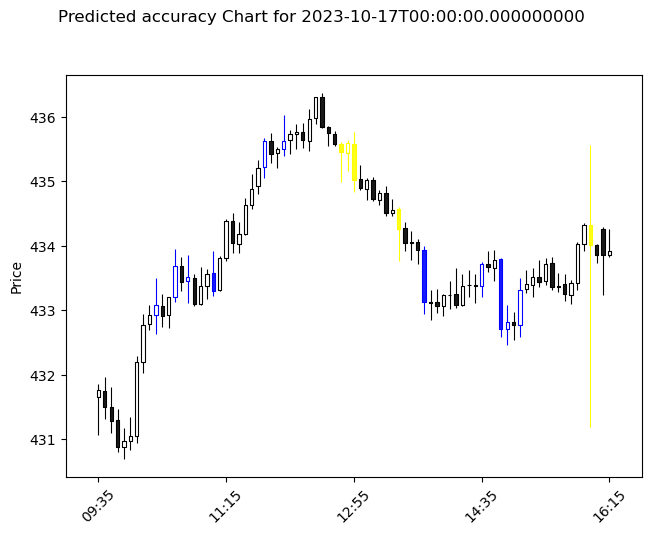

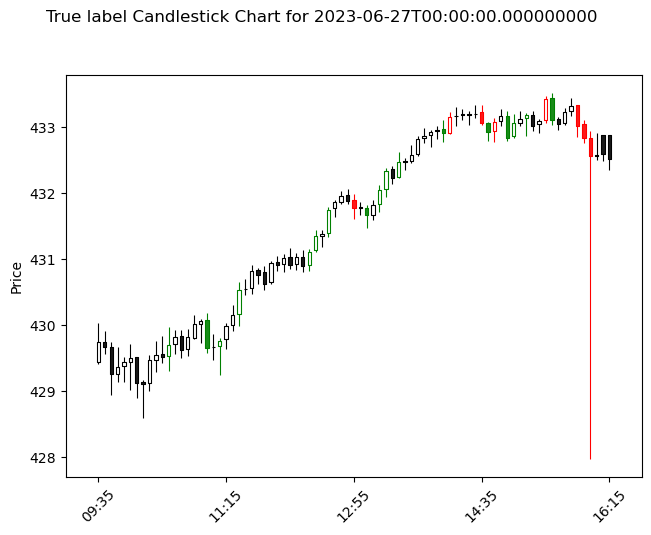

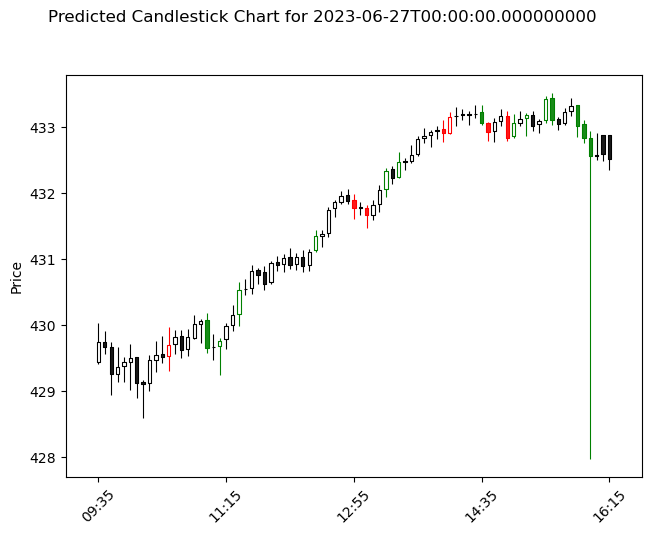

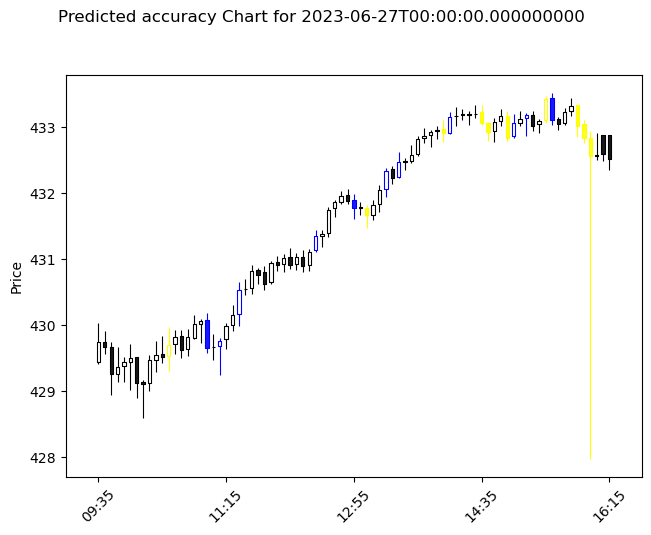

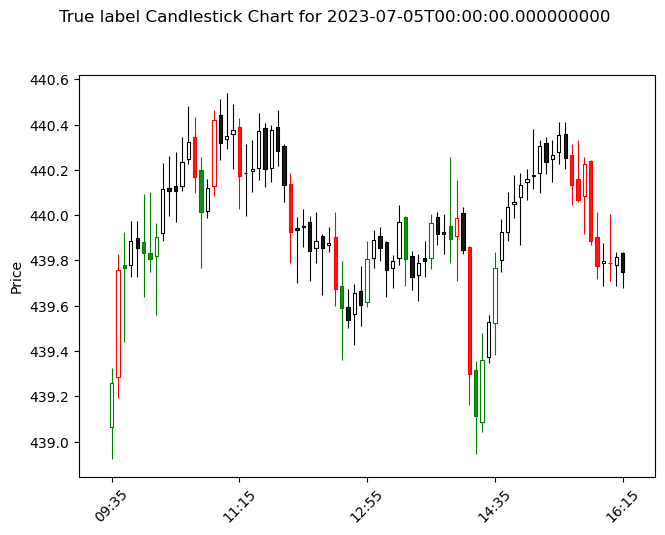

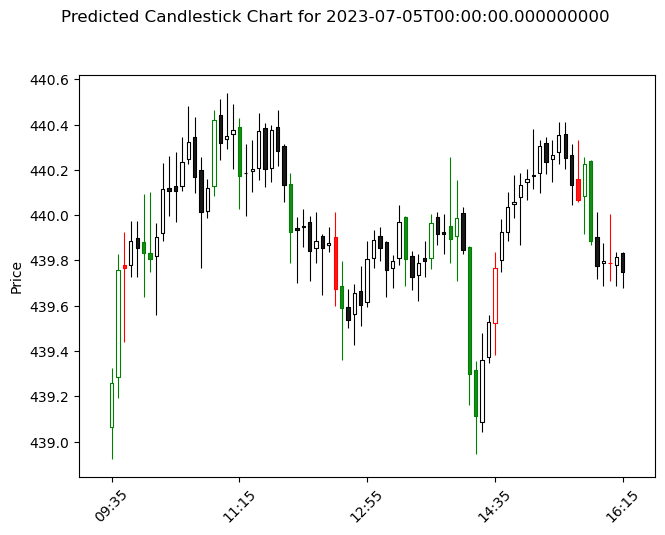

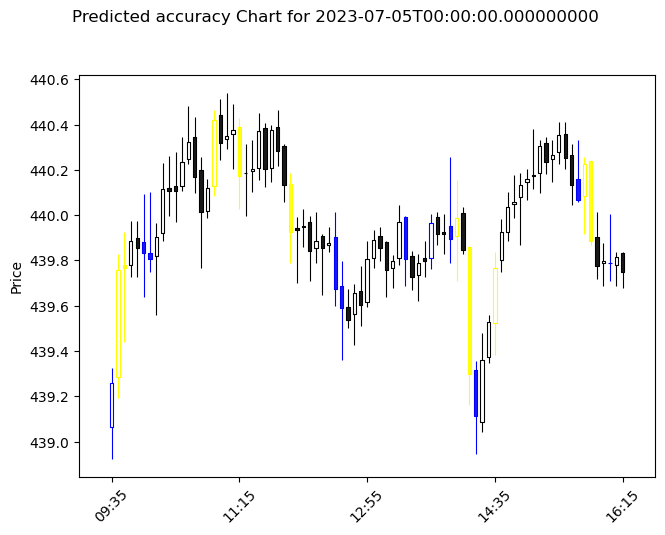

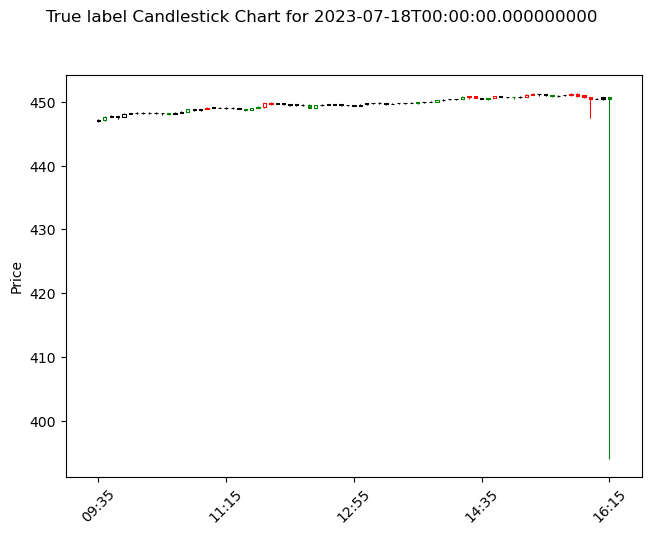

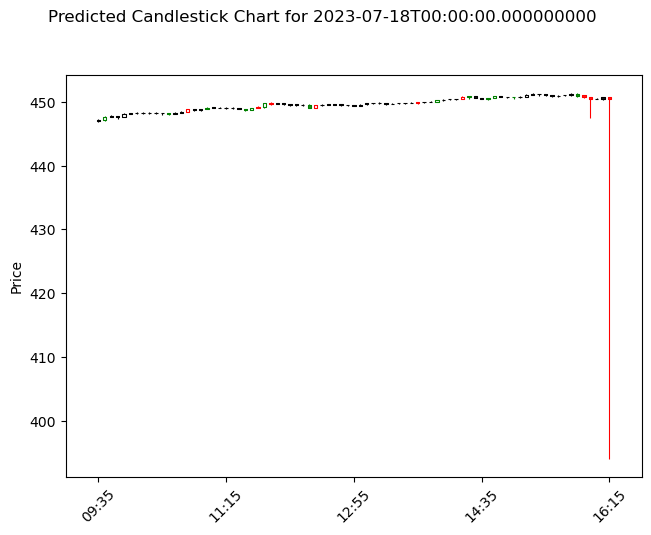

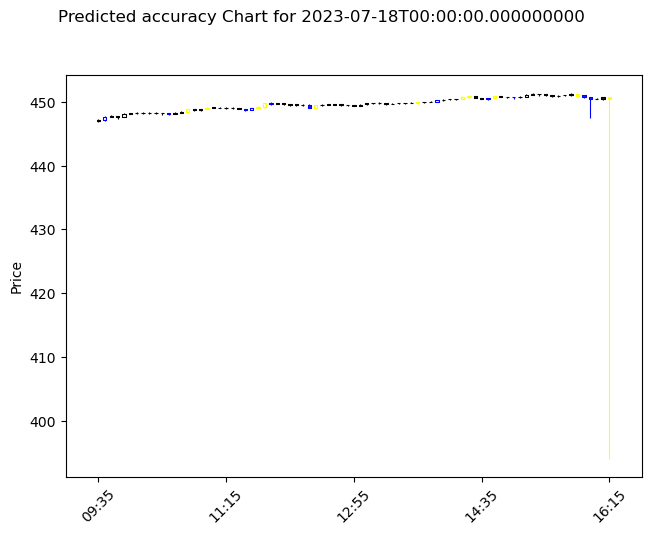

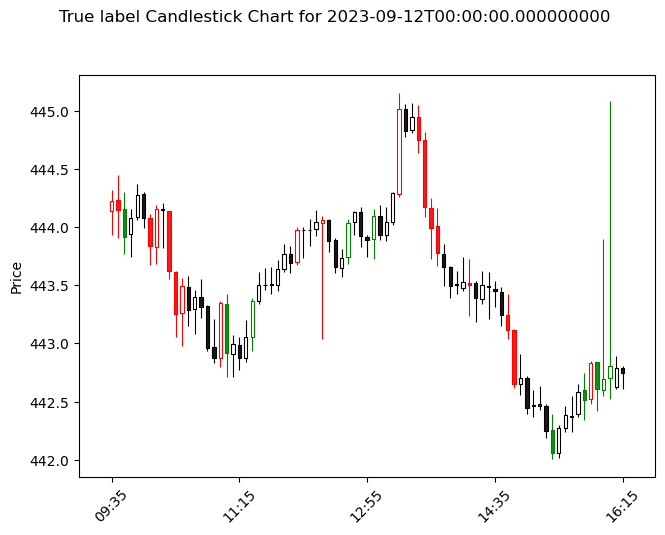

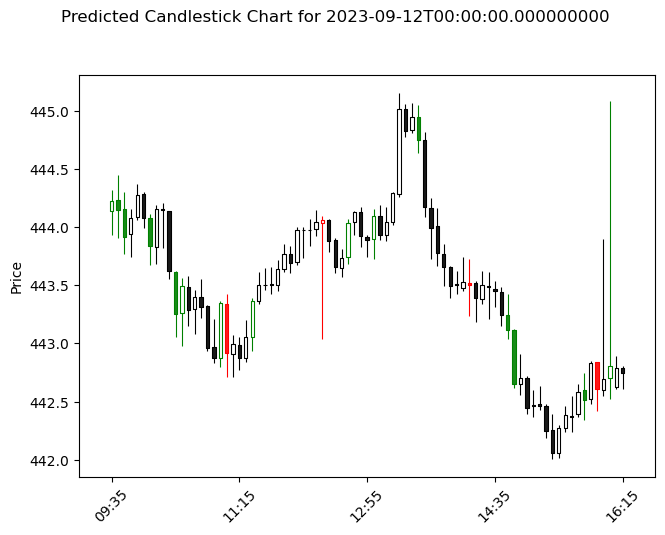

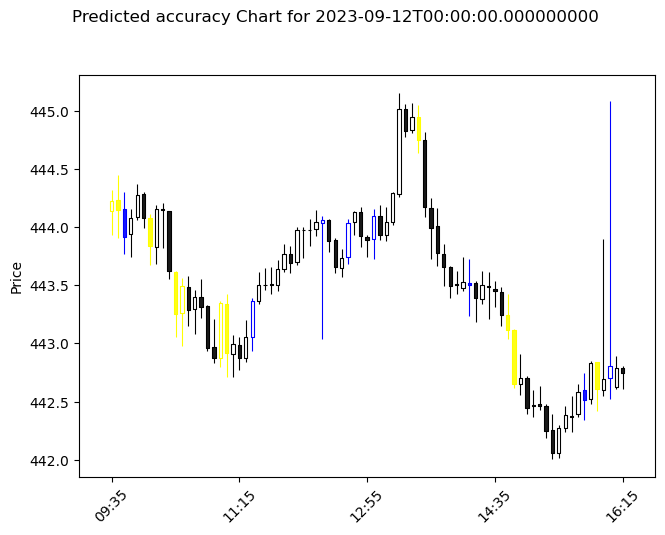

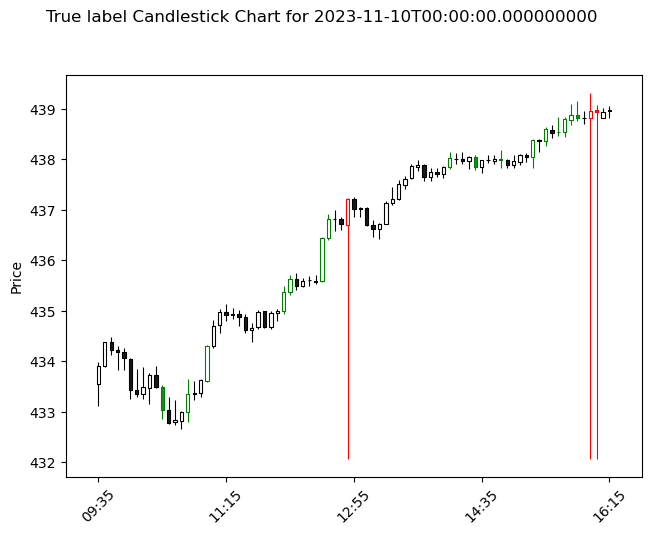

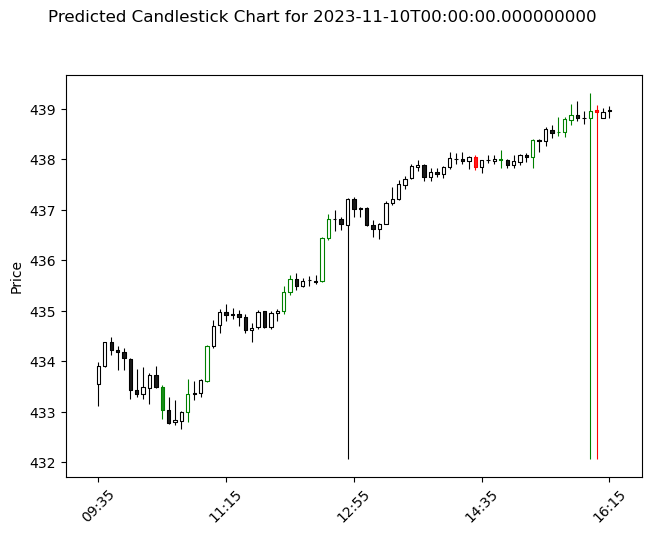

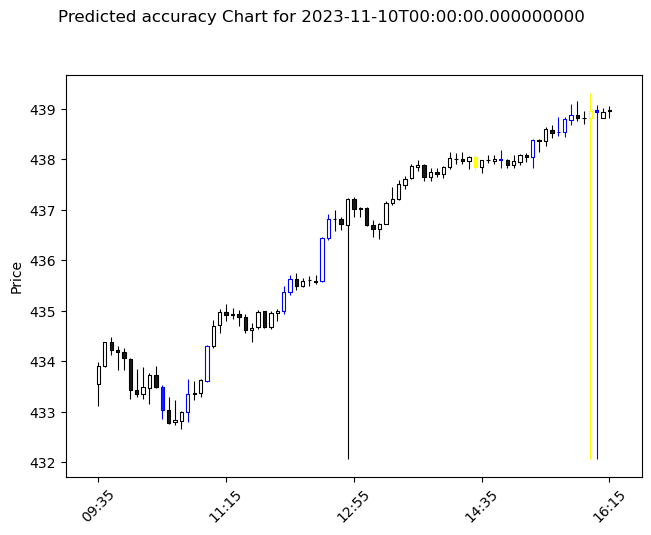

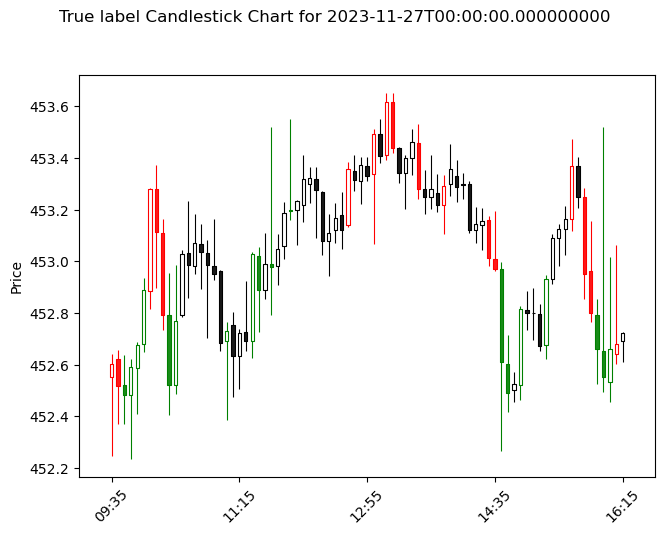

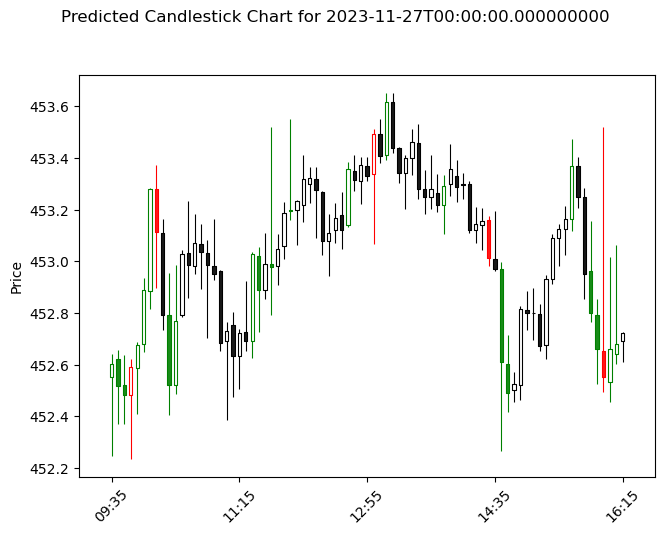

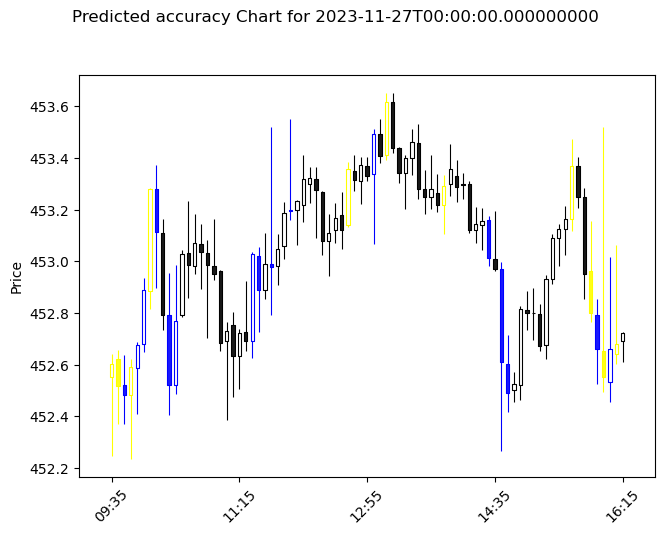

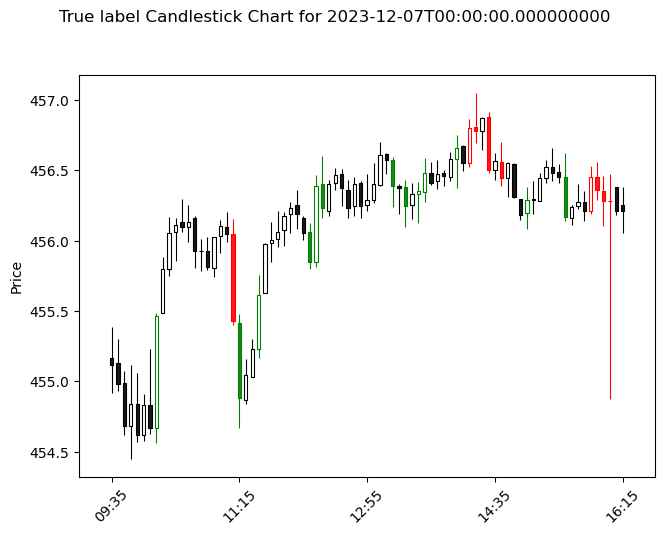

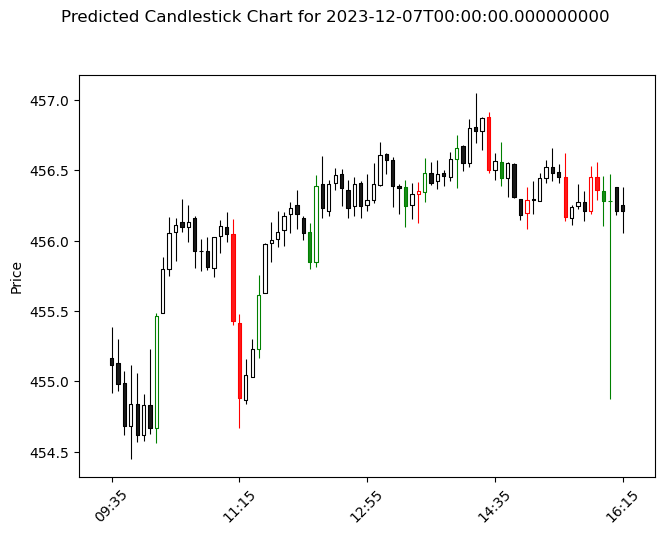

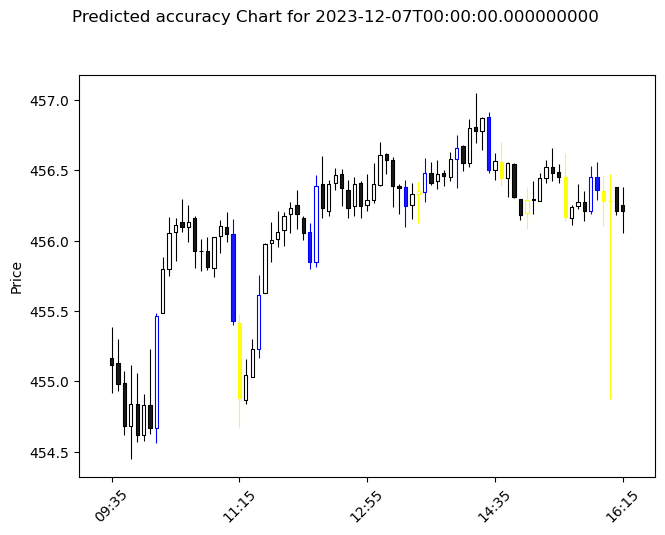

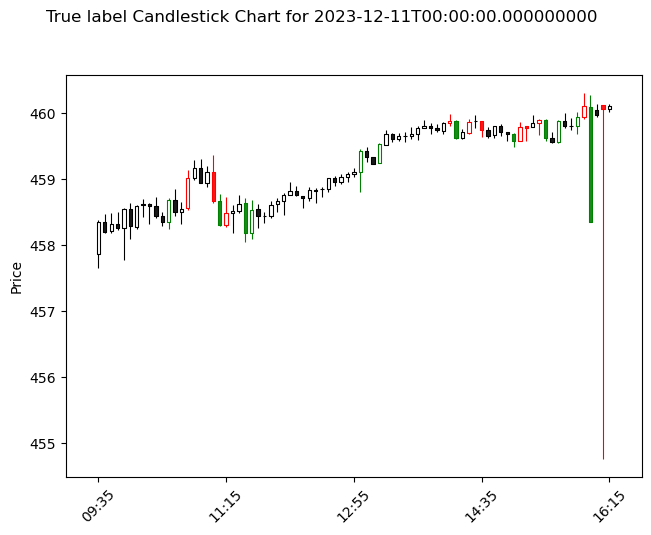

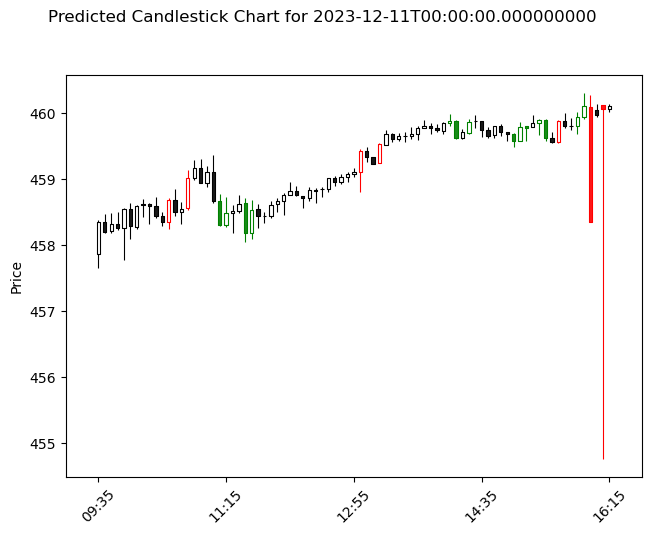

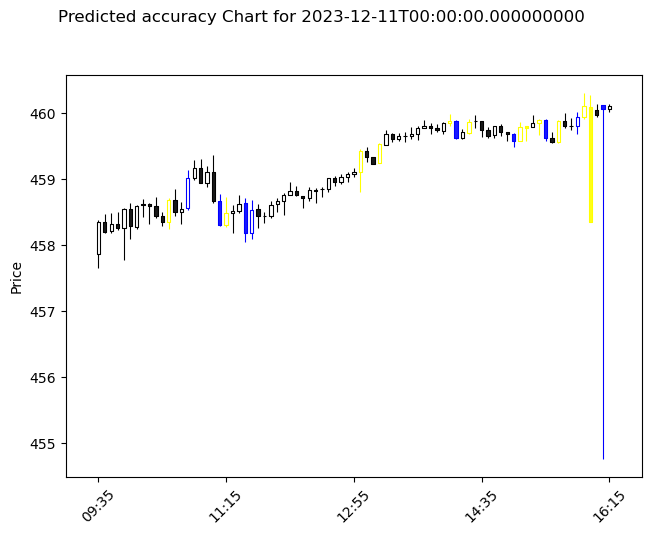

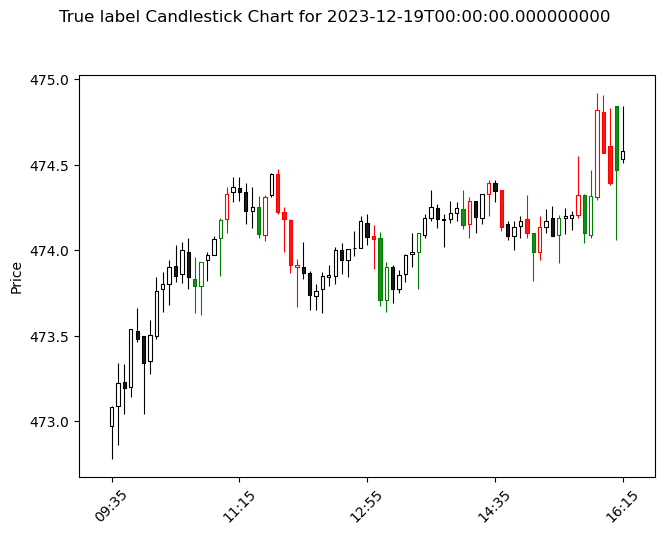

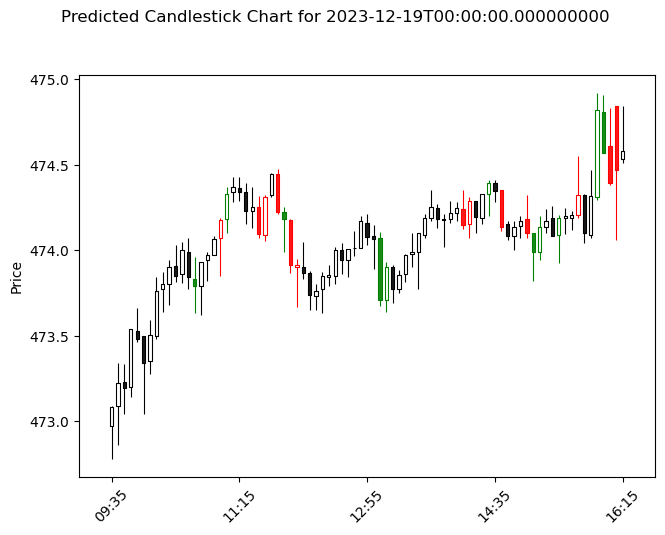

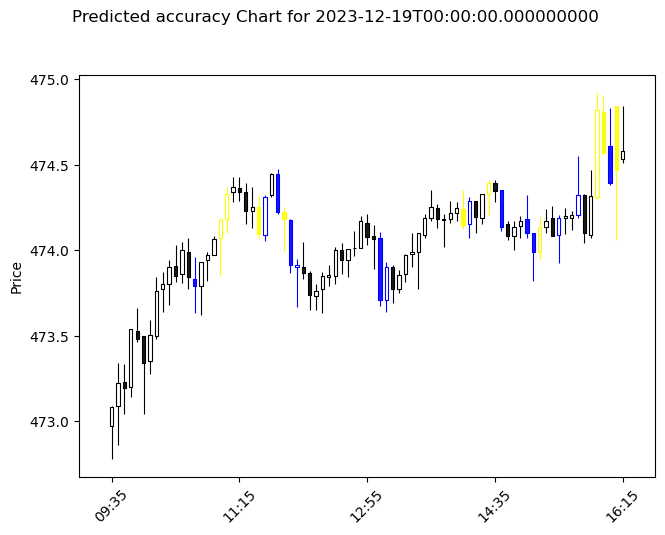

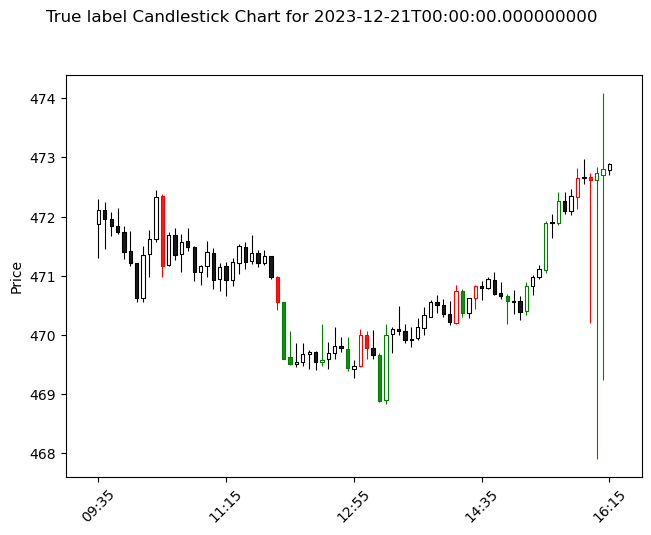

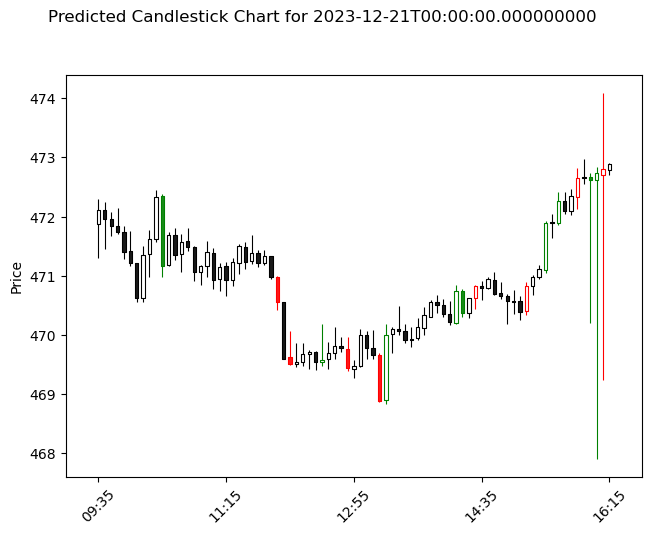

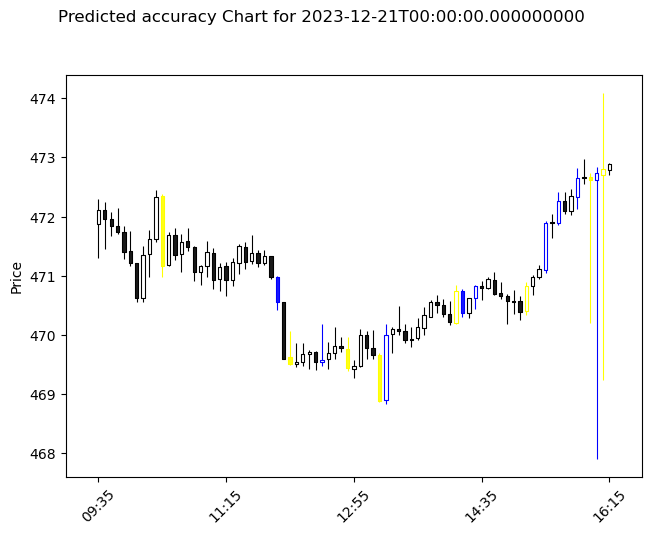

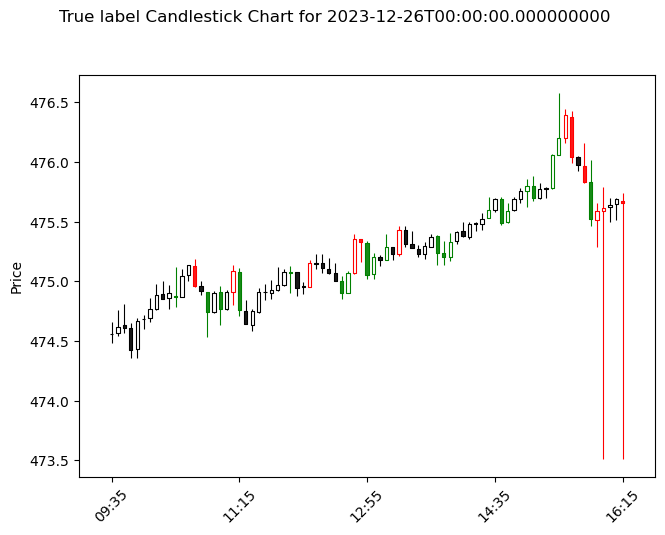

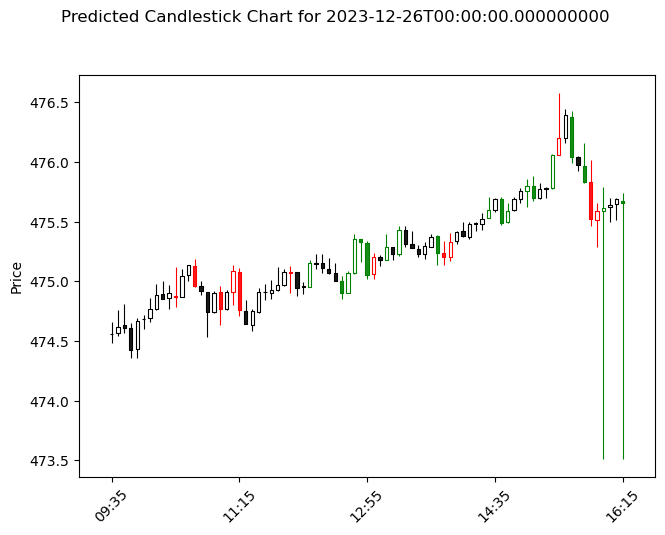

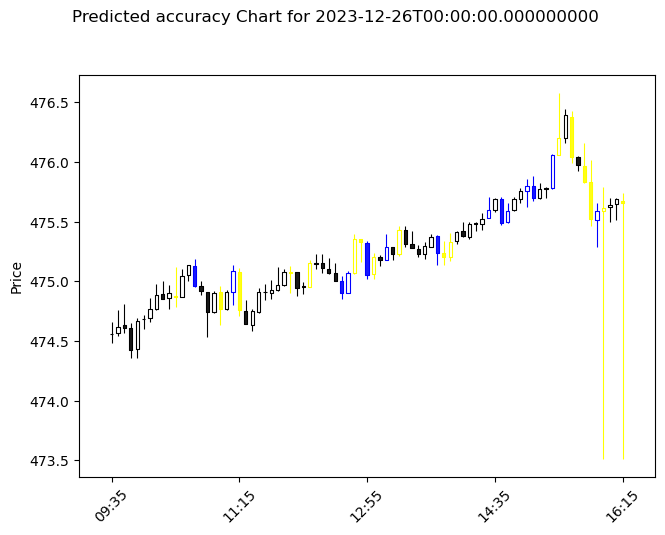

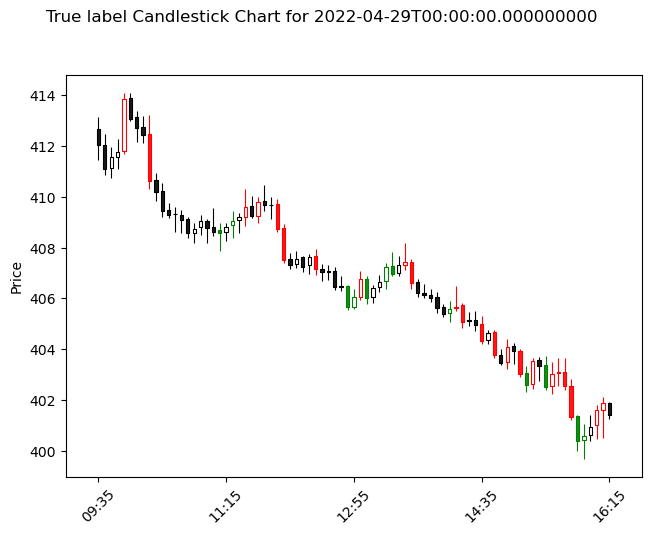

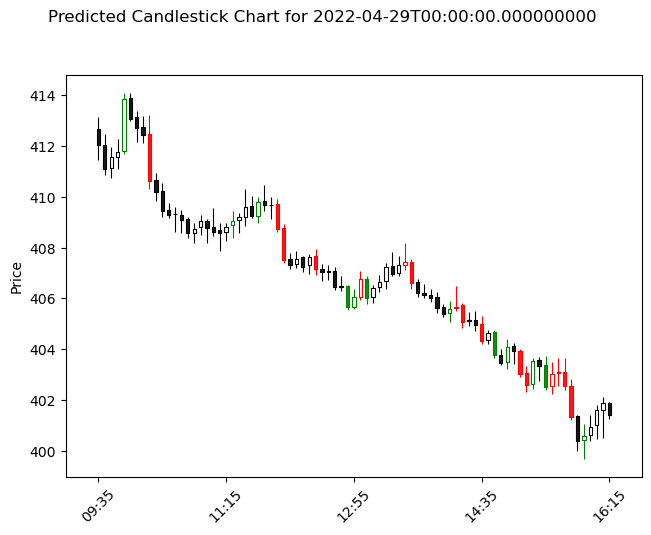

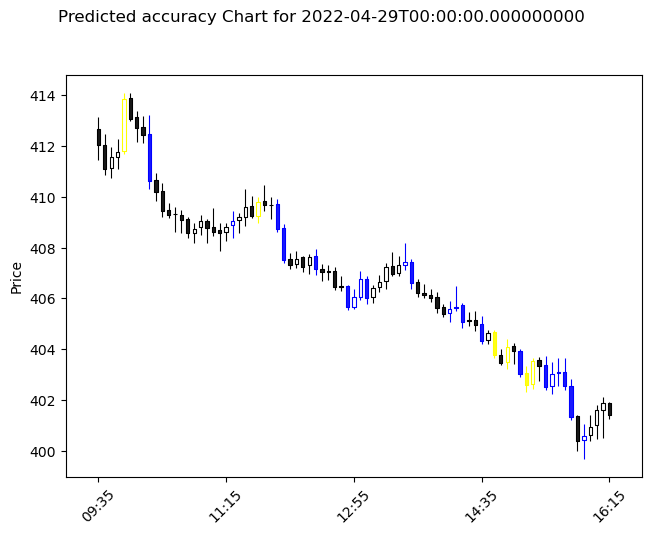

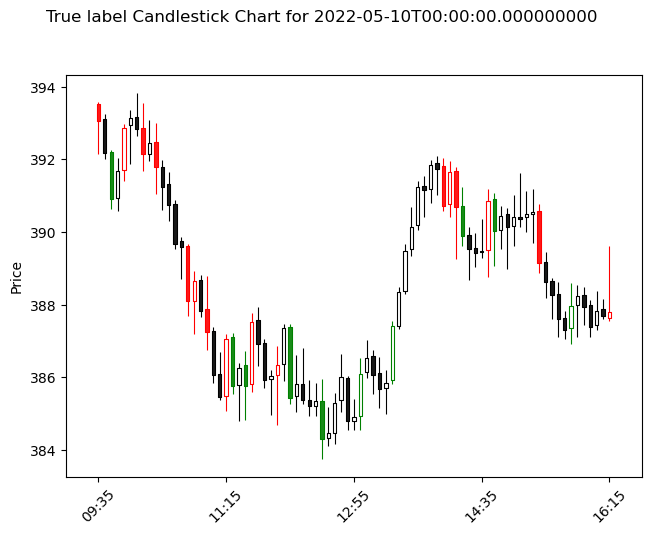

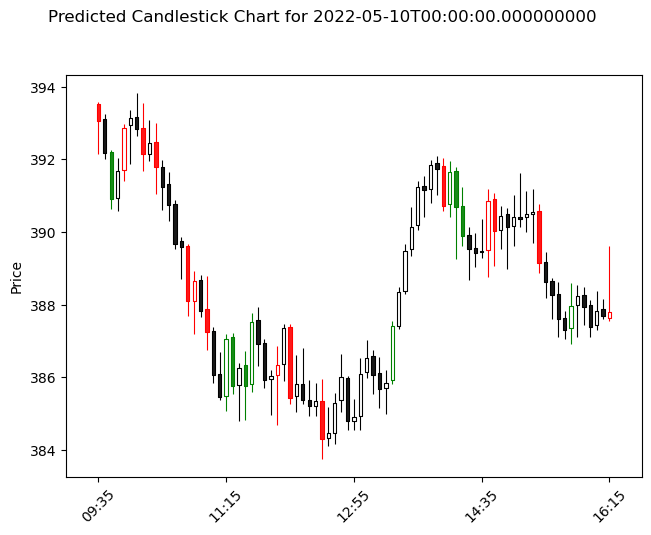

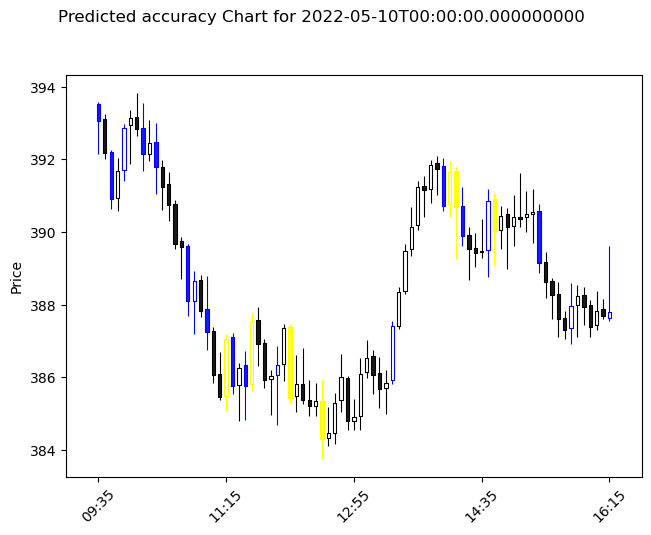

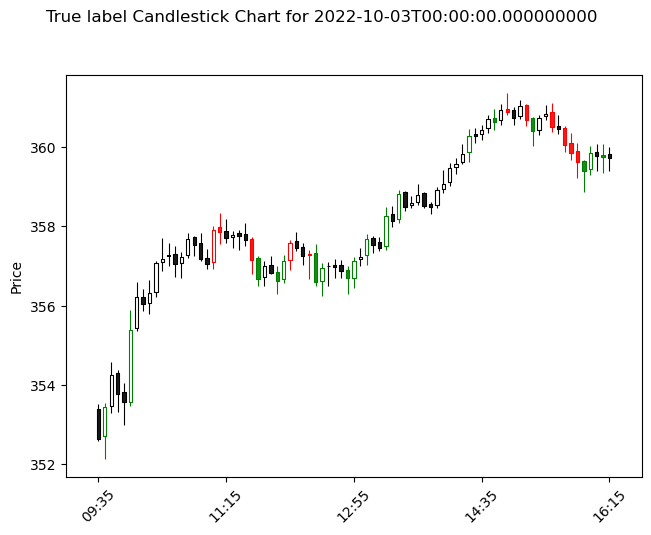

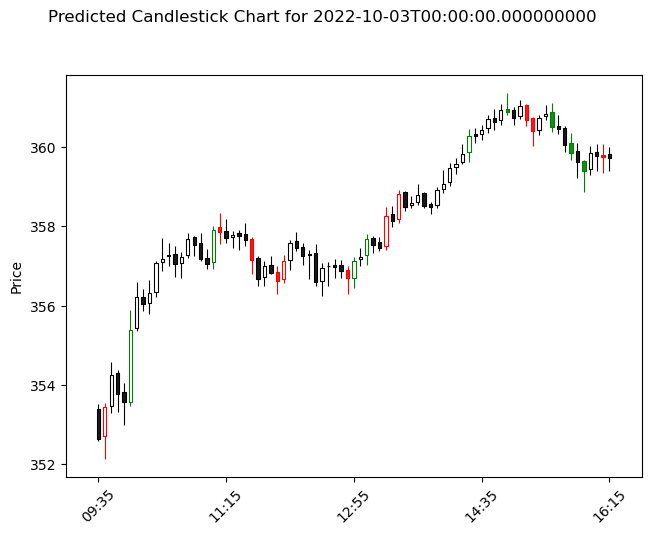

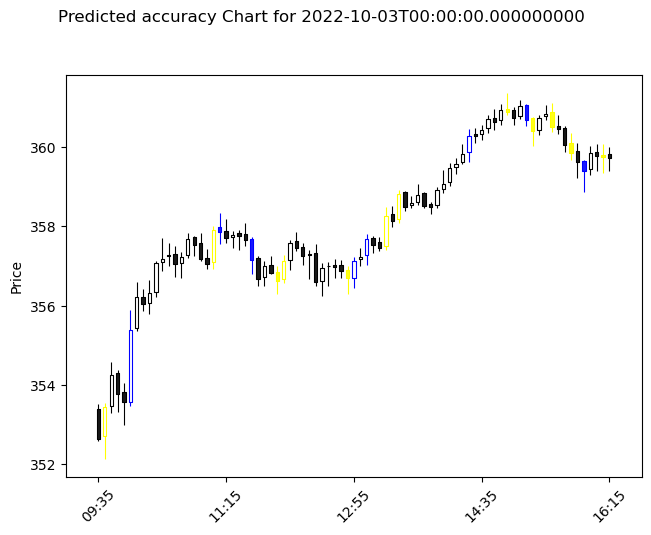

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


# Iterate over each unique date to create separate plots
for unique_date in unique_dates:
    # Filter data for the current date
    daily_data = test_data[test_data['Date'] == unique_date]

    # Create figure and axes
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    # Plot candlestick chart for true labels
    color_override = []
    for date, row in daily_data.iterrows():
        mc = mpf.make_marketcolors(up='white',down='k',
                                    edge='k',
                                    wick={'up':'k','down':'k'},
                                    volume='gray',
                                    ohlc='black')
        if row['label'] == 1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='green',
                                    edge='green',
                                    wick={'up':'green','down':'green'},
                                    volume='gray',
                                    ohlc='black')
        elif row['label'] == -1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='red',
                                    edge='red',
                                    wick={'up':'red','down':'red'},
                                    volume='gray',
                                    ohlc='black')
        color_override.append(mc)
    style  = mpf.make_mpf_style(marketcolors=mc)    
    # Plot ATR
    mpf.plot(daily_data, style=style, type='candle', marketcolor_overrides=color_override,title=f'True label Candlestick Chart for {unique_date}')

    # Plot candlestick chart for predicted labels
    color_override = []
    for date, row in daily_data.iterrows():
        mc = mpf.make_marketcolors(up='white',down='k',
                                    edge='k',
                                    wick={'up':'k','down':'k'},
                                    volume='gray',
                                    ohlc='black')
        if row['Predicted_Label'] == 1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='green',
                                    edge='green',
                                    wick={'up':'green','down':'green'},
                                    volume='gray',
                                    ohlc='black')
        elif row['Predicted_Label'] == -1 and row['highlight']:
            mc = mpf.make_marketcolors(up='white',down='red',
                                    edge='red',
                                    wick={'up':'red','down':'red'},
                                    volume='gray',
                                    ohlc='black')
            
        color_override.append(mc)
    style  = mpf.make_mpf_style(marketcolors=mc)    
    # Plot ATR
    mpf.plot(daily_data, style=style, type='candle', marketcolor_overrides=color_override,title=f'Predicted Candlestick Chart for {unique_date}')
    
    
    
    color_override = []
    for date, row in daily_data.iterrows():
        mc = mpf.make_marketcolors(up='white',down='k',
                                    edge='k',
                                    wick={'up':'k','down':'k'},
                                    volume='gray',
                                    ohlc='black')
        if row['Predicted_Label'] == 1 or row['Predicted_Label'] == -1:
            if row['Predicted_Label'] == row['label'] and row['highlight']:
                mc = mpf.make_marketcolors(up='white',down='blue',
                                        edge='blue',
                                        wick={'up':'blue','down':'blue'},
                                        volume='gray',
                                        ohlc='black')
            elif row['Predicted_Label'] != row['label'] and row['highlight']:
                mc = mpf.make_marketcolors(up='white',down='yellow',
                                        edge='yellow',
                                        wick={'up':'yellow','down':'yellow'},
                                        volume='gray',
                                        ohlc='black')
            
        color_override.append(mc)
    style  = mpf.make_mpf_style(marketcolors=mc)    
    # Plot ATR
    mpf.plot(daily_data, style=style, type='candle', marketcolor_overrides=color_override,title=f'Predicted accuracy Chart for {unique_date}')